# `ModelForge`
### Amortise your Forwards Models

This example is deigned to give a quick overview of how to use `ModelForge` to amortise a forward model.

The main classes we will use are `MLPAmortisedModel`, and `SupervisedAmortiser`

We will use a slightly more complex example, showing how to jointly amortise the recovery of both stellar position (via tip-tilt) and stellar flux. 

As an example we will use the simplest MLP model, with a depth of zero, plus the `ModelForge` `SimpleLinear` layer used as a learning rate filter!

In [1]:
# Packages
import jax
import zodiax as zdx
import equinox as eqx
import dLux as dl
import optax

# Modules
from jax import numpy as np, random as jr, tree_util as jtu
from dLux import layers as dll, utils as dlu
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm.notebook import tqdm

# Model Forge
import ModelForge as forge

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 96
%matplotlib inline

In [2]:
import itertools

# NOTE: Ive kept this in the notebook because its not quite robust enough yet
def build_hyper_trainer(joint_model, **kwargs):
    """This is just a co-pilot clever way to automate hyper param creation, lr must be
    supplied. All inputs must be iterables. Not lr will always appear as a hyper
    parameter."""
    fmodel = joint_model.fmodel
    params = joint_model.params

    # Ensure there is a lr
    if "lr" not in kwargs.keys():
        raise ValueError("lr must be supplied")

    # Iterate over all combinations of hyper parameters
    keys, values = list(kwargs.keys()), list(kwargs.values())

    # Ensure we know what all the hyper parameters are
    for key in keys:
        if key not in ["lr", "depth", "width"]:
            raise ValueError(f"Unknown hyper parameter {key}")

    optimisers, optims, hypers = [], [], []
    for combination in itertools.product(*values):
        # Build hyper parameters into a dict
        hyperparams = dict(zip(keys, combination))

        # Save values to list
        hypers.append(hyperparams)

        # Built the optimiser's-optimiser
        optims.append(optax.adam(hyperparams["lr"]))

        # Build the optimiser
        # Manually feed in the hyper parameters, because dict.pop removes value even
        # after its been passed into the hypers list... Fuck mutability
        optimisers.append(
            forge.MLPAmortisedModel(
                fmodel, params, depth=hyperparams["depth"], width=hyperparams["width"]
            ).optimiser
        )

    # Return the trainer
    return forge.HyperTrainer(joint_model, optimisers, optims, hypers)

## Make The Forwards Model

In [3]:
# Source parameters
wavelengths = 1e-6 * np.linspace(1.0, 1.2, 5)
source = dl.PointSource(wavelengths, flux=1e4)

# Wavefront parameters
wf_npix = 256
aper_diam = 2.4

# Generate an aperture manually
coords = dlu.pixel_coords(5 * wf_npix, 2.4)
spider_angles = 45 + np.linspace(0, 360, 4, endpoint=False)
outer = dlu.circle(coords, aper_diam / 2)
inner = dlu.circle(coords, 0.3, True)
spiders = dlu.spider(coords, 0.05, spider_angles)
aperture = dlu.combine([outer, inner, spiders], 5)

# Generate zernike aberrations
coords = dlu.pixel_coords(wf_npix, 2.4)
zernikes = np.arange(2, 10)
# zernikes = np.arange(2, 4)
zernikes = [2, 3, 7, 8, 9, 10]
basis = np.array([1e-9 * dlu.zernike(i, coords, aper_diam) for i in zernikes])
coeffs = jr.normal(jr.PRNGKey(0), (len(zernikes),))

# PSF parameters
psf_wf_npix = 64
sampling = 3  # ie 1.5x Nyquist
psf_oversample = 2
fringe_size = dlu.fringe_size(wavelengths, aper_diam).min()
psf_pix_scale = 1.22 * dlu.rad2arcsec(fringe_size) / sampling

# Construct optics & Telescope
layers = [("aperture", dll.BasisOptic(aperture, basis, coeffs, normalise=True))]
optics = dl.AngularOptics(
    wf_npix, aper_diam, layers, psf_wf_npix, psf_pix_scale / psf_oversample
)
fmodel = dl.Telescope(optics, source)

## Examine

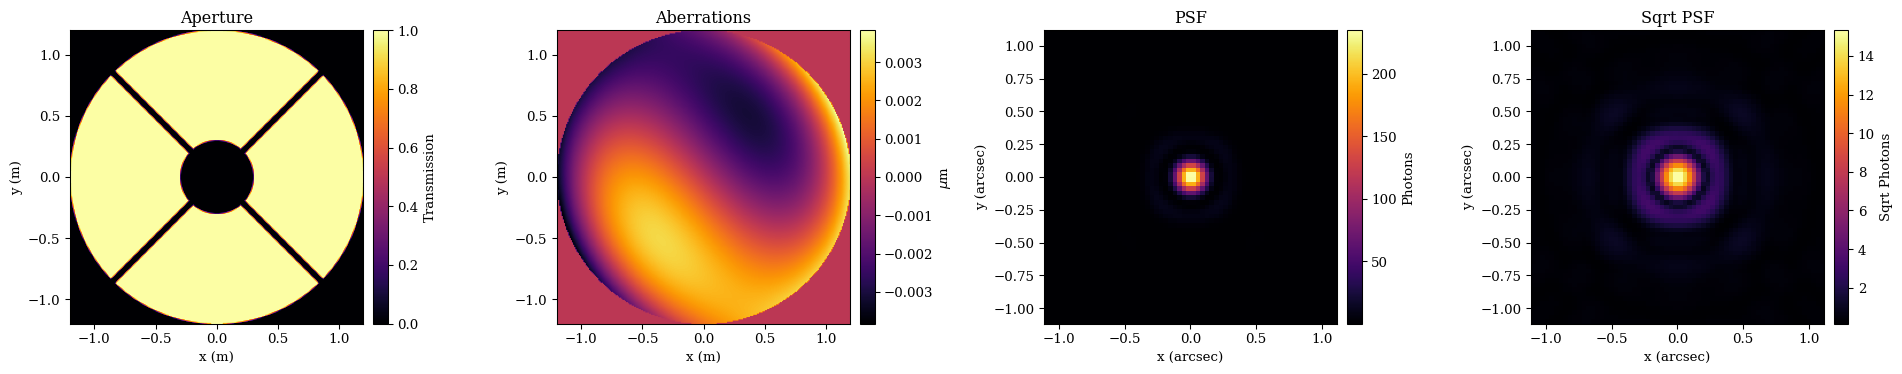

In [4]:
from ModelForge import plotting as p

fig, axes = forge.plot_grid_2d(1, 4)

# Aperture plots
r = aper_diam / 2
extent = (-r, r, -r, r)

axes[0].set(xlabel="x (m)", ylabel="y (m)", title="Aperture")
im = axes[0].imshow(optics.transmission, extent=extent)
forge.add_cbar(fig, axes[0], im, label="Transmission")

axes[1].set(xlabel="x (m)", ylabel="y (m)", title="Aberrations")
im = axes[1].imshow(1e6 * optics.eval_basis(), extent=extent)
forge.add_cbar(fig, axes[1], im, label="$\mu$m")

# PSF plots
psf = fmodel.model()
r = psf_pix_scale * psf_wf_npix / 2
extent = (-r, r, -r, r)

axes[2].set(xlabel="x (arcsec)", ylabel="y (arcsec)", title="PSF")
im = axes[2].imshow(psf, extent=extent)
forge.add_cbar(fig, axes[2], im, label="Photons")

axes[3].set(xlabel="x (arcsec)", ylabel="y (arcsec)", title="Sqrt PSF")
im = axes[3].imshow(psf**0.5, extent=extent)
forge.add_cbar(fig, axes[3], im, label="Sqrt Photons")
fig.tight_layout()

# Generate Samples

Two options here, a single parameter and multiple parameters, just to show that they both work

In [5]:
# Example one: A single parameter
params = ["coefficients"]
joint_model = forge.MLPAmortisedModel(fmodel, params, depth=2, init_scale=2e0)

# # Generate training and testing distributions
# truth_prior = [forge.Normal(mu=0, sigma=10, bc_shape=coeffs.shape)]
# train_prior = [forge.Normal(mu=0, sigma=50, bc_shape=coeffs.shape)]

# This is trying to recover an aberrated psf from an unaberrated one
truth_prior = [forge.Normal(mu=0, sigma=25, bc_shape=coeffs.shape)]
train_prior = [forge.Normal(mu=0, sigma=25, bc_shape=coeffs.shape)]

In [6]:
# # Example 2: Two parameters
# params = ["coefficients", "flux"]
# # joint_model = forge.MLPAmortisedModel(fmodel, params, depth=2, init_scale=1e-1)
# fmodel = fmodel.set('flux', np.array([1e4]))
# print(fmodel.flux.shape)
# print(fmodel.coefficients.shape)
# joint_model = forge.MLPAmortisedModel(fmodel, params, depth=2, init_scale=2e0)

# # Generate training and testing distributions
# truth_prior = [
#     forge.Normal(mu=0, sigma=10, bc_shape=coeffs.shape),
#     forge.Normal(mu=1e4, sigma=100)
# ]
# train_prior = [
#     forge.Normal(mu=0, sigma=50, bc_shape=coeffs.shape),
#     forge.Normal(mu=1e4, sigma=100)
# ]

## Examine the initialisation performance

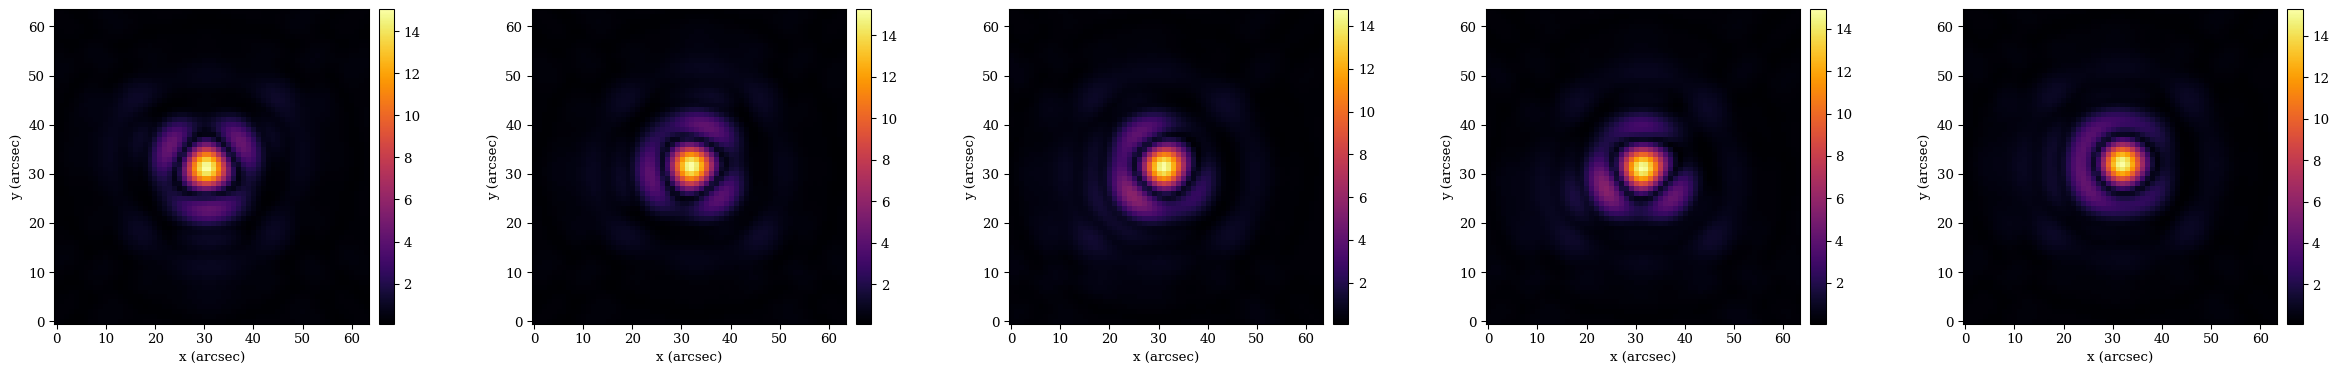

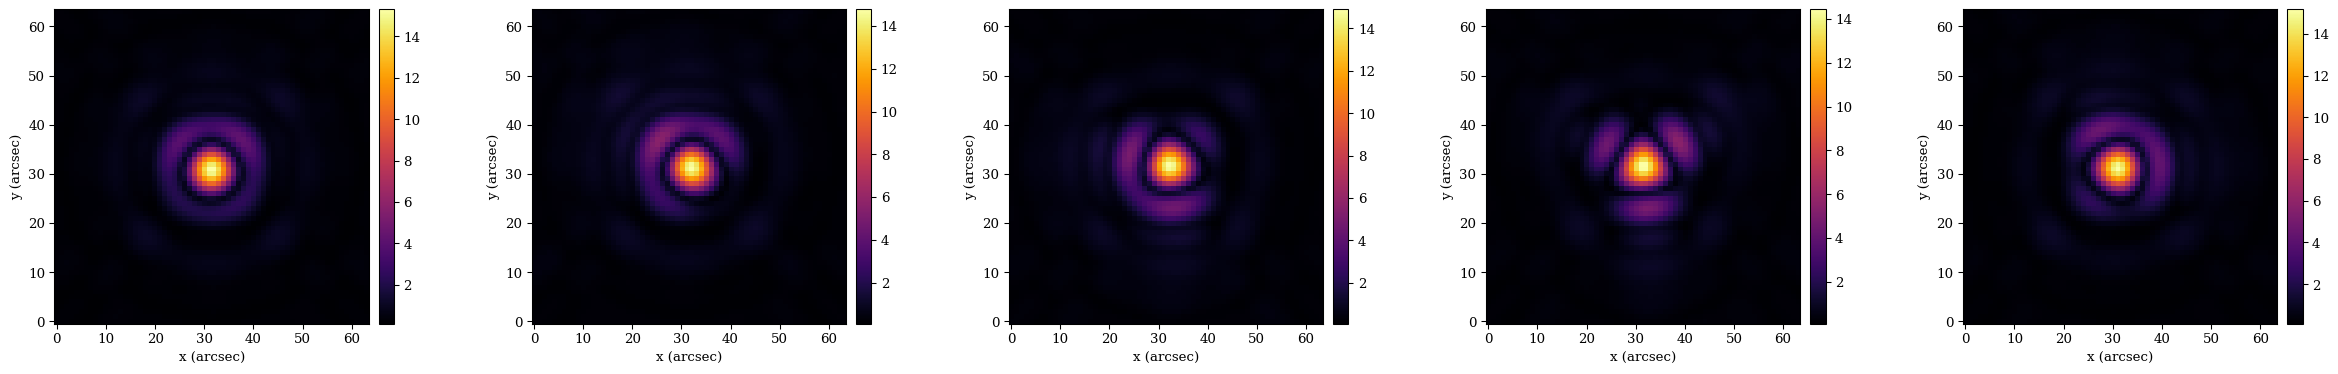

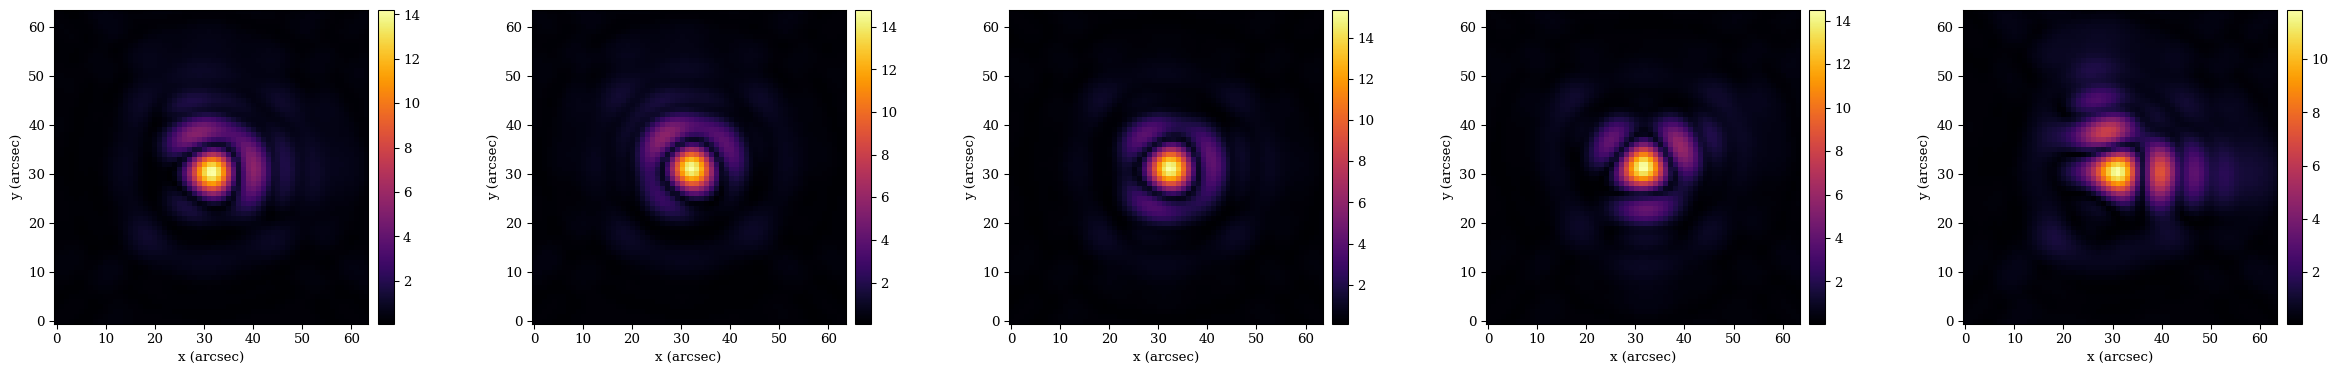

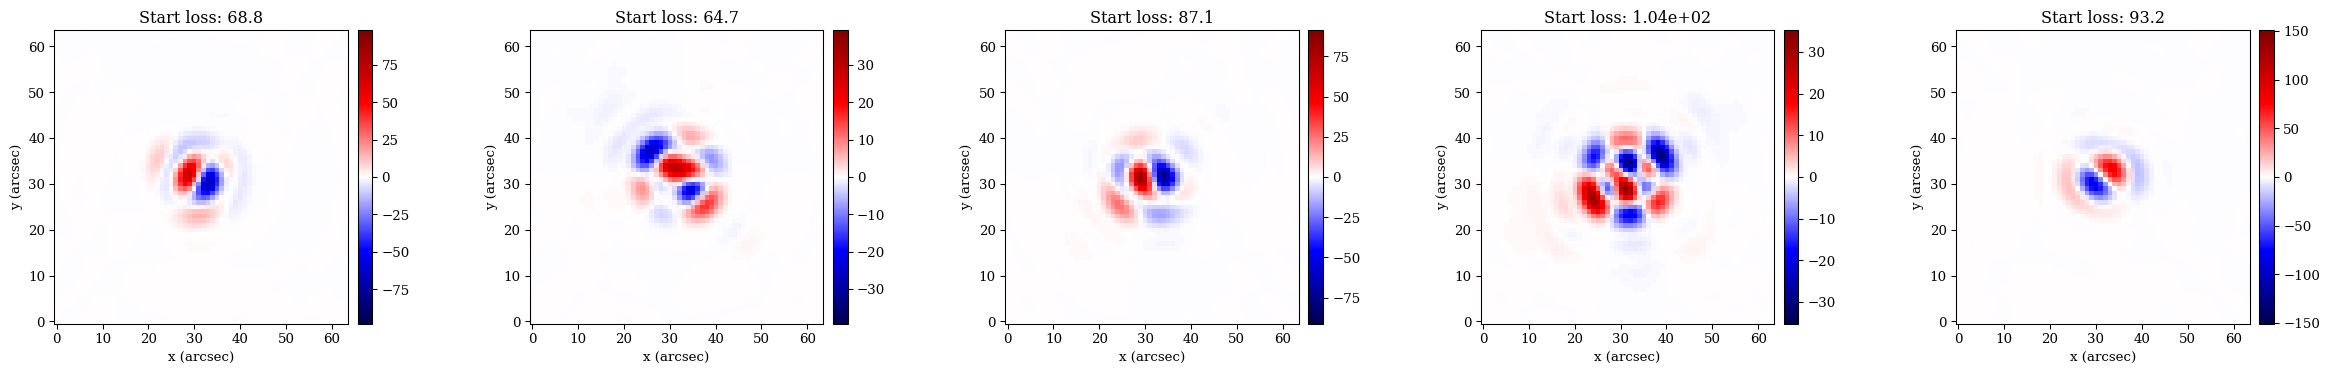

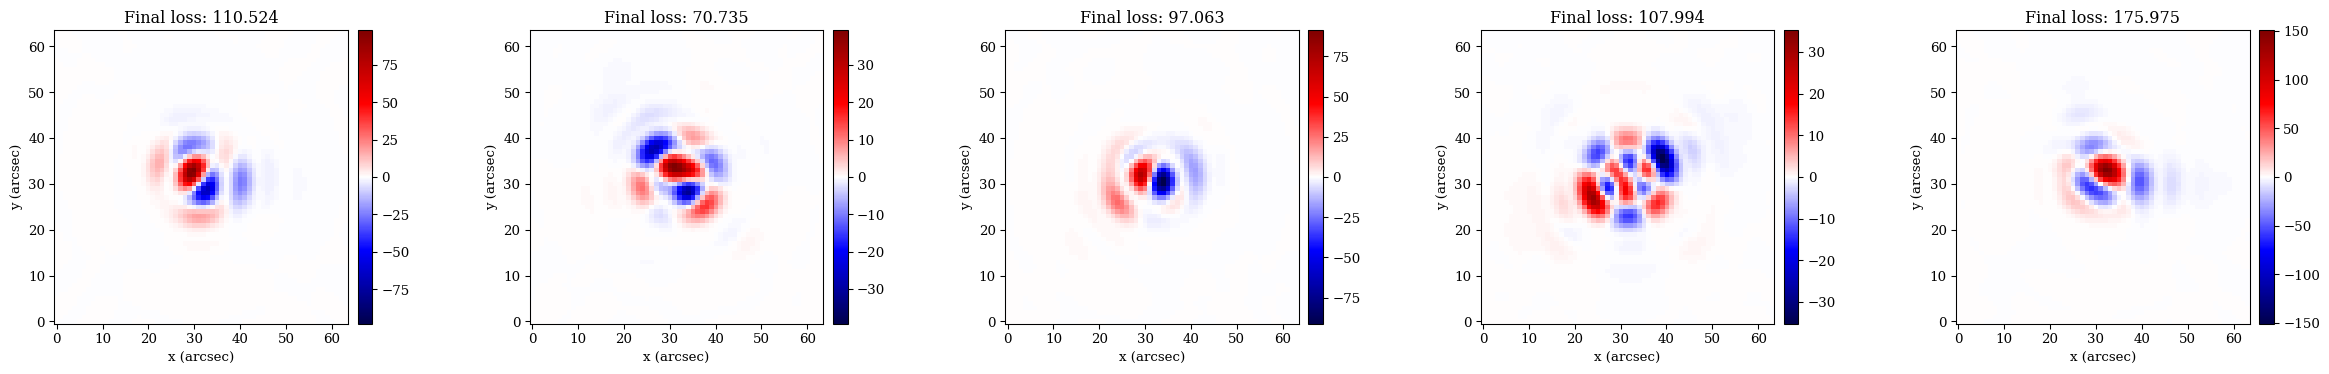

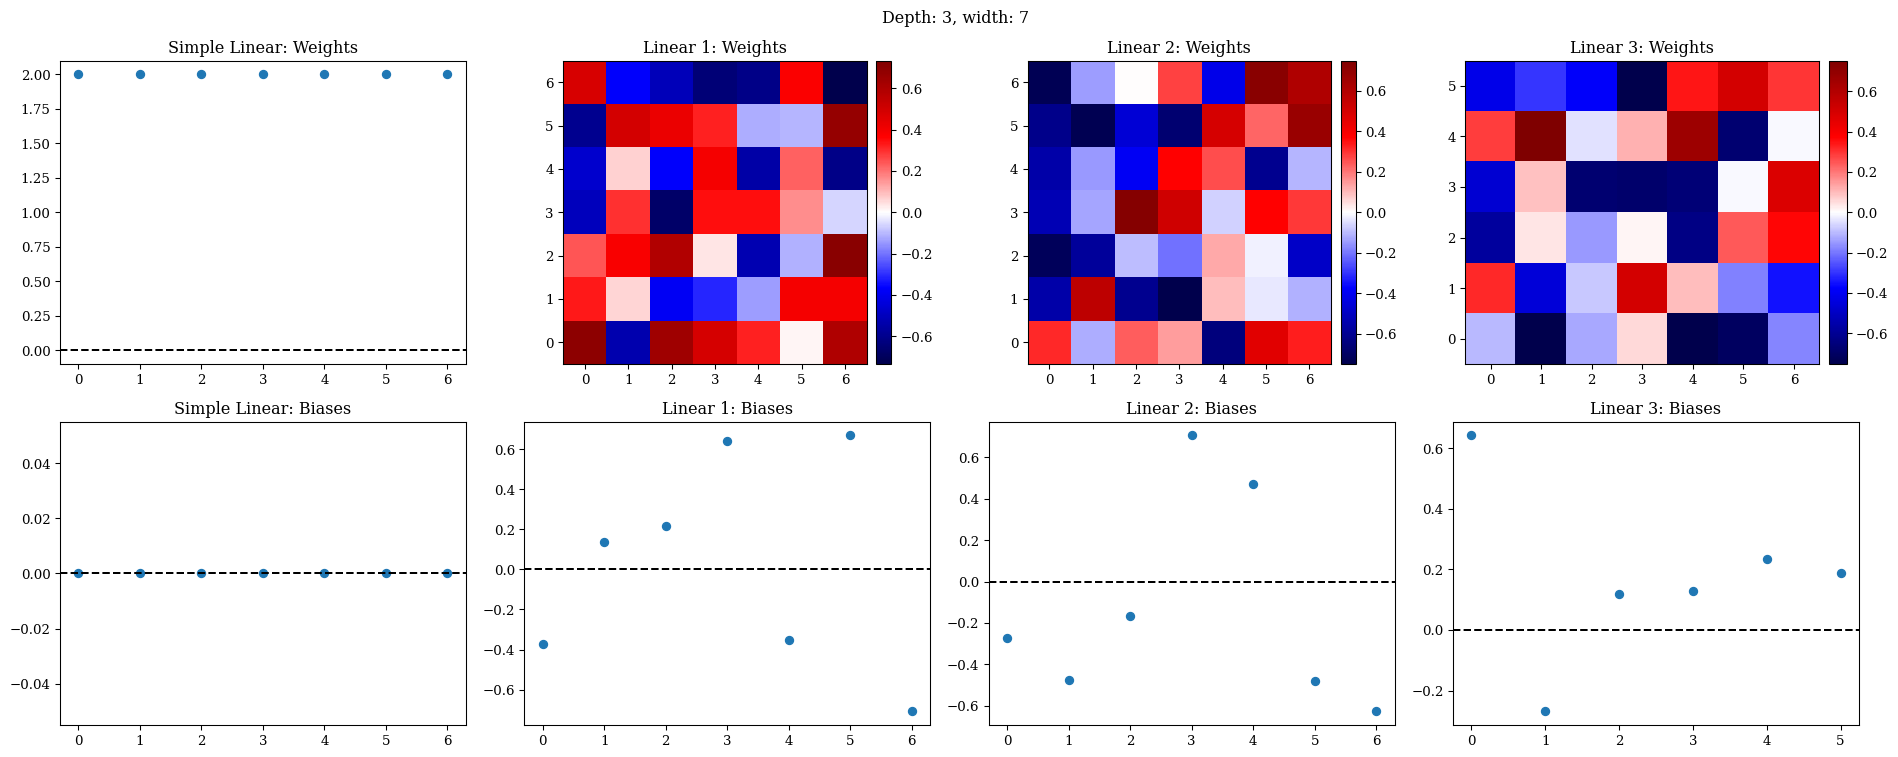

In [7]:
r, c = 1, 5
true, key = forge.sample(truth_prior, r * c, jr.PRNGKey(0))
train, key = forge.sample(train_prior, r * c, key)

# Get target and sample psfs
target_psfs = joint_model.model_samples(true)
sample_psfs = joint_model.model_samples(train)

# Get predicted psfs
predicted = eqx.filter_vmap(joint_model.predict)(train, target_psfs)
predicted_psfs = joint_model.model_samples(predicted)

p = .5

# Plot truth - sample points
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(target_psfs[i]**p)#, cmap="seismic", vmin=-vs[i], vmax=vs[i])
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        # title=f"Start loss: {initial_loss[i]:.3}",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()

# Plot truth - predicted
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(sample_psfs[i]**p)#, cmap="seismic", vmin=-vs[i], vmax=vs[i])
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        # title=f"Final loss: {final_losses[i]:.3f}",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()

# Plot truth - predicted
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(predicted_psfs[i]**p)#, cmap="seismic", vmin=-vs[i], vmax=vs[i])
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        # title=f"Final loss: {final_losses[i]:.3f}",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()

# We can examine the initialisation conditions here if we want
forge.examine_predictions(joint_model, truth_prior, train_prior, 1, 5)
forge.visualise_optimiser(joint_model.optimiser)

In [8]:
np.linspace(-2, -1, 5)

Array([-2.  , -1.75, -1.5 , -1.25, -1.  ], dtype=float32)

Training 90 optimisers, compile times may be long.
Training 90 Optimisers over 1 steps on 1000 PSFs for 1000 epochs.
Total forwards model grad evaluations per epoch: 1000.
Compiling step function... Done! Took 75.14s


Best:   0%|          | 0/1000 [00:00<?, ?it/s]

LR:       0     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1
Depth:    0        0        0        0        0        0        0        1        1        1        1        1        1        2        2        2        2        2        2     

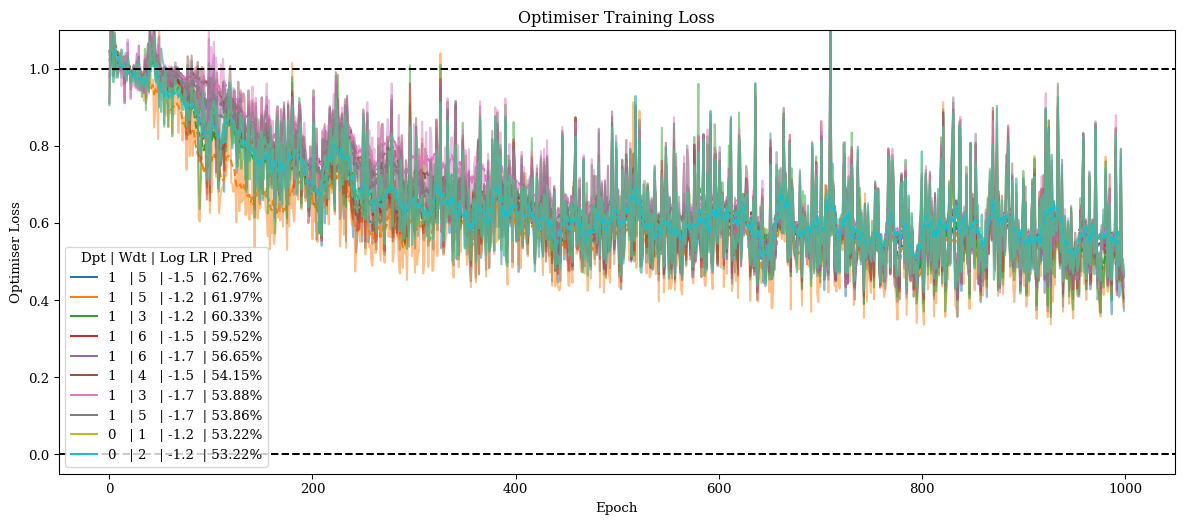

In [9]:
# NOTE! Compile times scale linearly with the number of hyper parameters, however this
# typically has no effect on runtime performance because the expensive part of the
# training is the calculation of forwards model gradients which is done once and then
# passed to all the optimisers in parallel. This allows us to perform a very large
# hyper parameter, with almost zero performance hit per epoch.

# Compile time currently scales linearly with batch size? - test this

# As a rough gauge, compile time seemed to be ~1-2s per hyper parameter combination

# Define hyperparameters and build our hyper-trainer
# TODO: Reduce the max lr to  1e-1, all the 1e0's perform very poorly
lrs = 10 ** np.linspace(-2, -1, 5)
depths = [0, 1, 2]
widths = np.linspace(1, 6, 6).astype(int)
hyper_trainer = build_hyper_trainer(joint_model, lr=lrs, depth=depths, width=widths)

# Train
hyper_trainer, train_key = hyper_trainer.train_stochastic(
    truth_prior, train_prior, epochs=1000, batch_size=1000, key=jr.PRNGKey(0),
)

# TODO: Plot histogram of each optimiser performance grouped by hyper parameter

# TODO: class method that returns the mean loss of the last n epochs, and optionally, 
# the index of the best performing optimiser
# TODO: Similar that just returns the indices 
# TODO: Also add a 'get_ith' that returns all the components of the ith optimiser 
# and hyper params. As a dict?


# Plot results
# Note: No legend since we have 99 hyper params
# Note: This can take a long time to run, since it plots all 99 optimisers for all epochs
# TODO: plot histogram of final losses
hyper_trainer.plot_losses()

# TODO: print depth and width as (d, w)
# TODO: The hyper-parameters dont line up with the losses.

# Note that the progress -bar displays the best 5 performing optimisers per-epoch

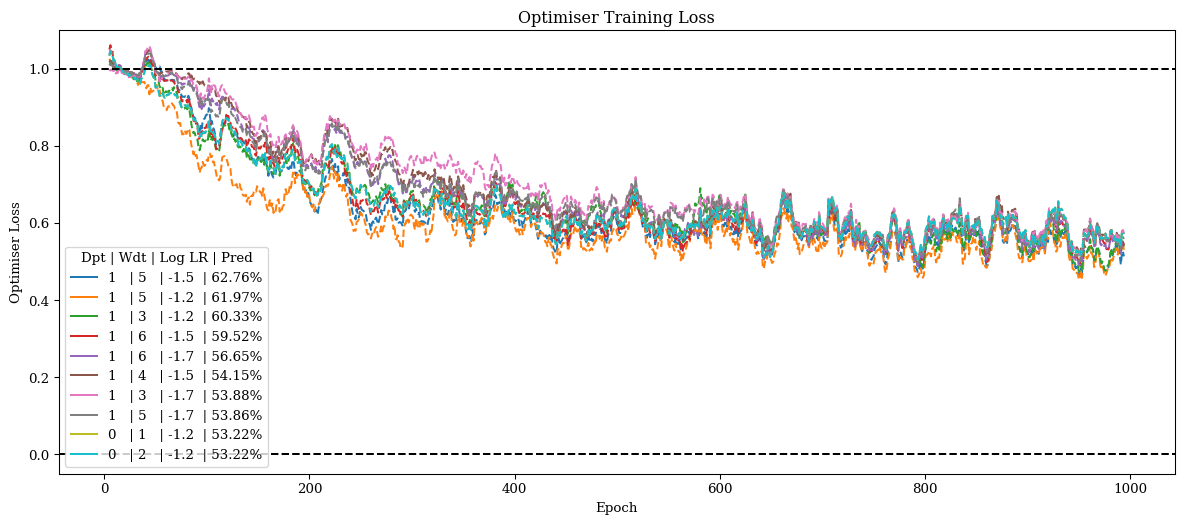

In [10]:
hyper_trainer.plot_losses(n_top=10, plot_losses=False)

**How easy was that!**

Now lets gets the best of the ensemble and examine both how it performs, and its structure

  0%|          | 0/12 [00:00<?, ?it/s]

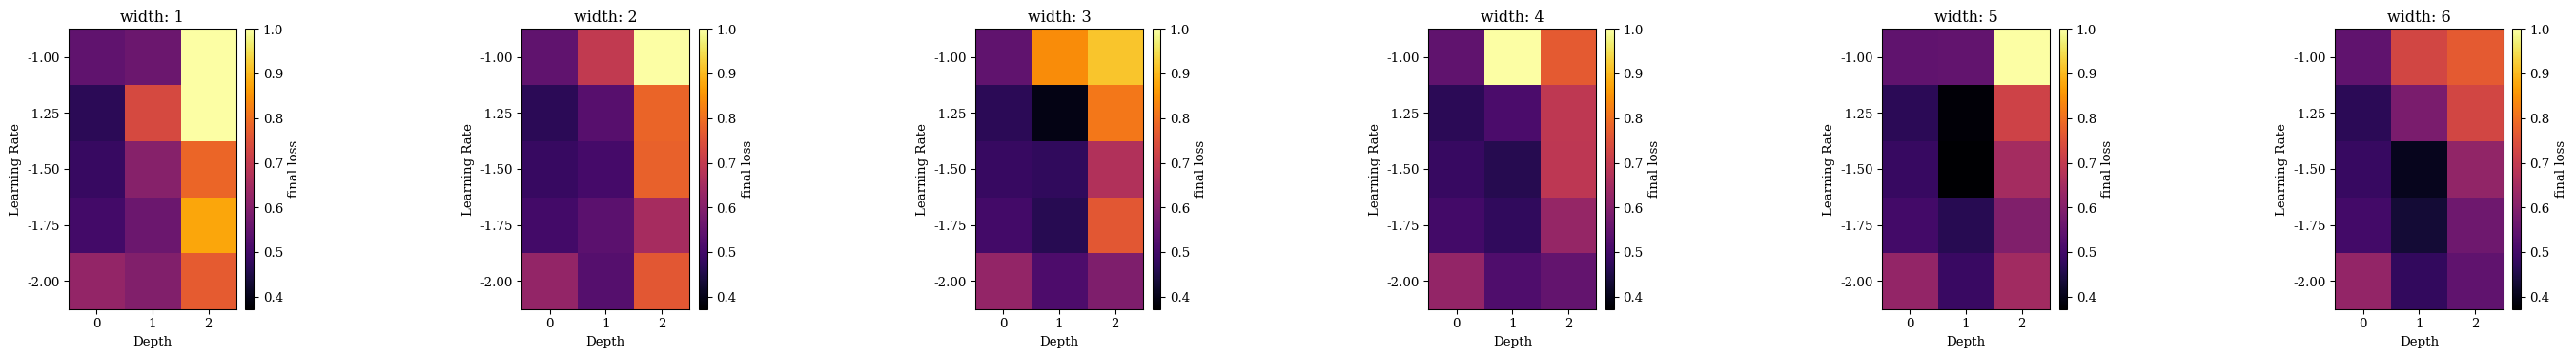

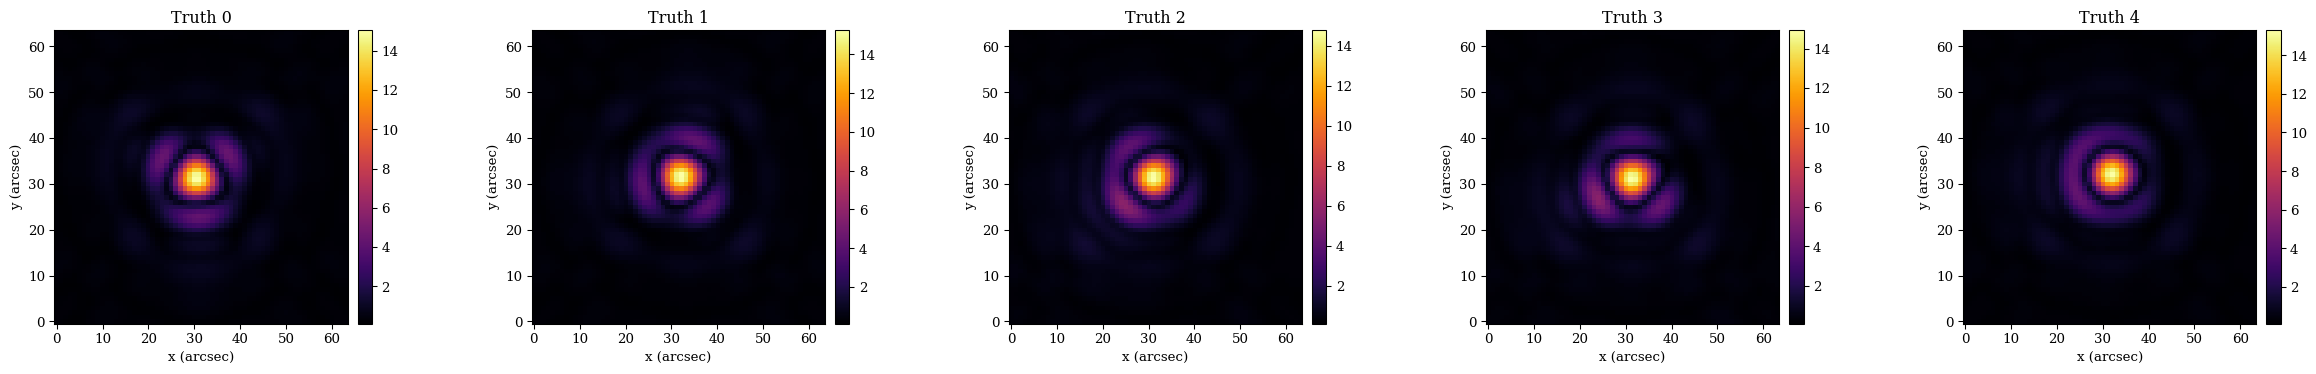

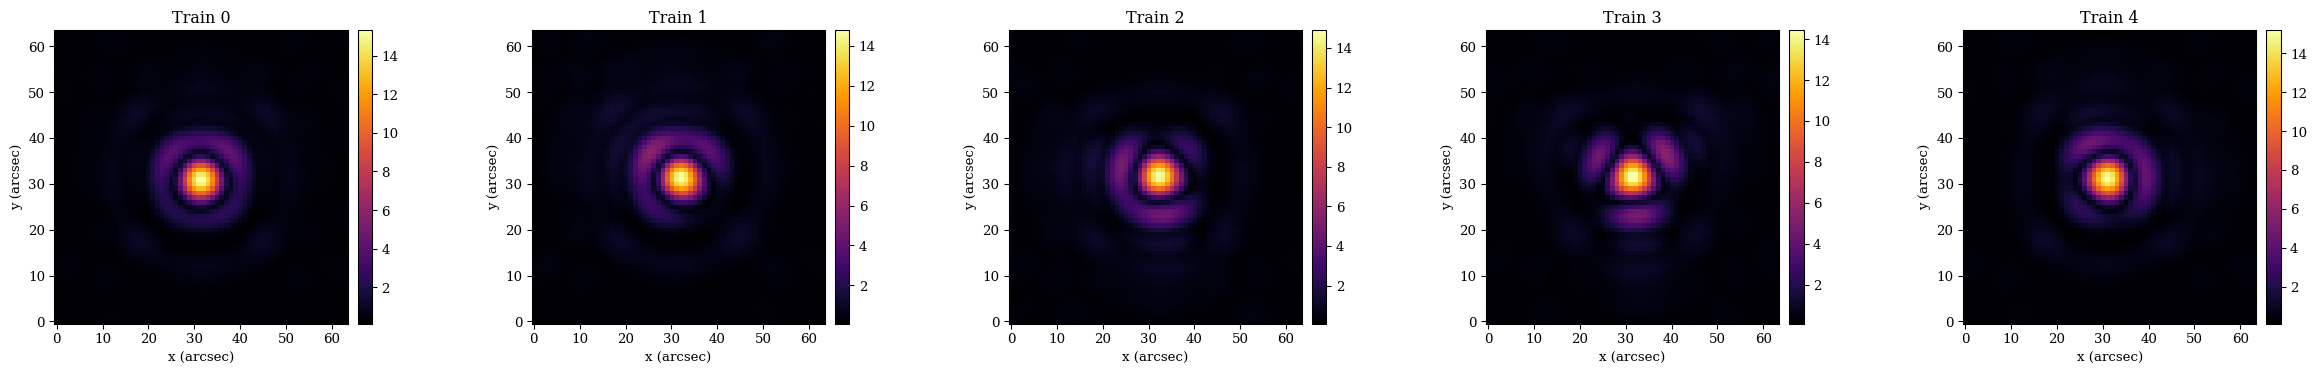

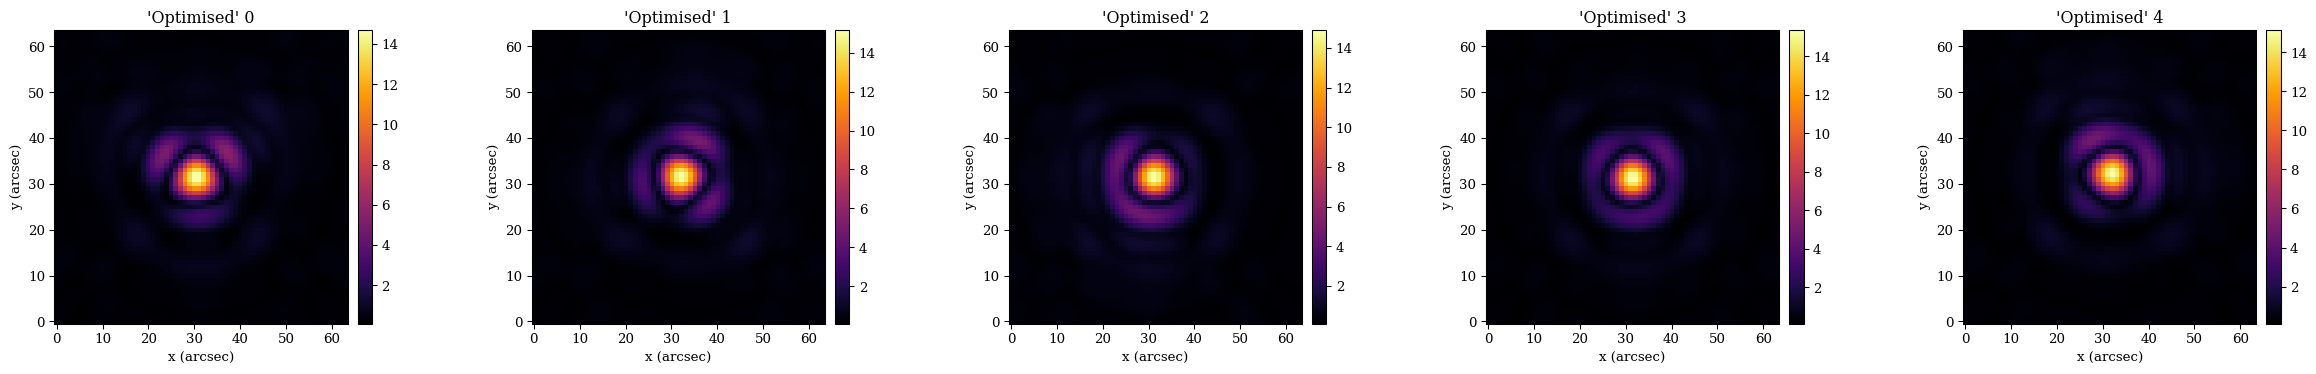

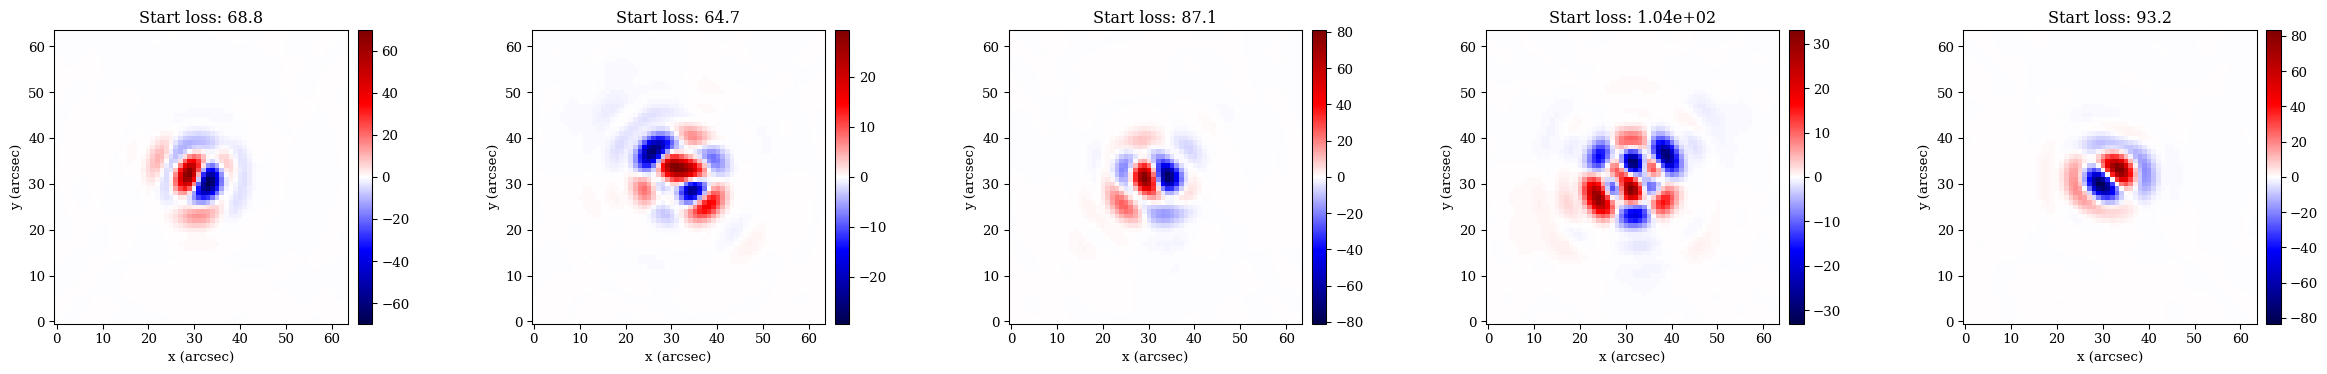

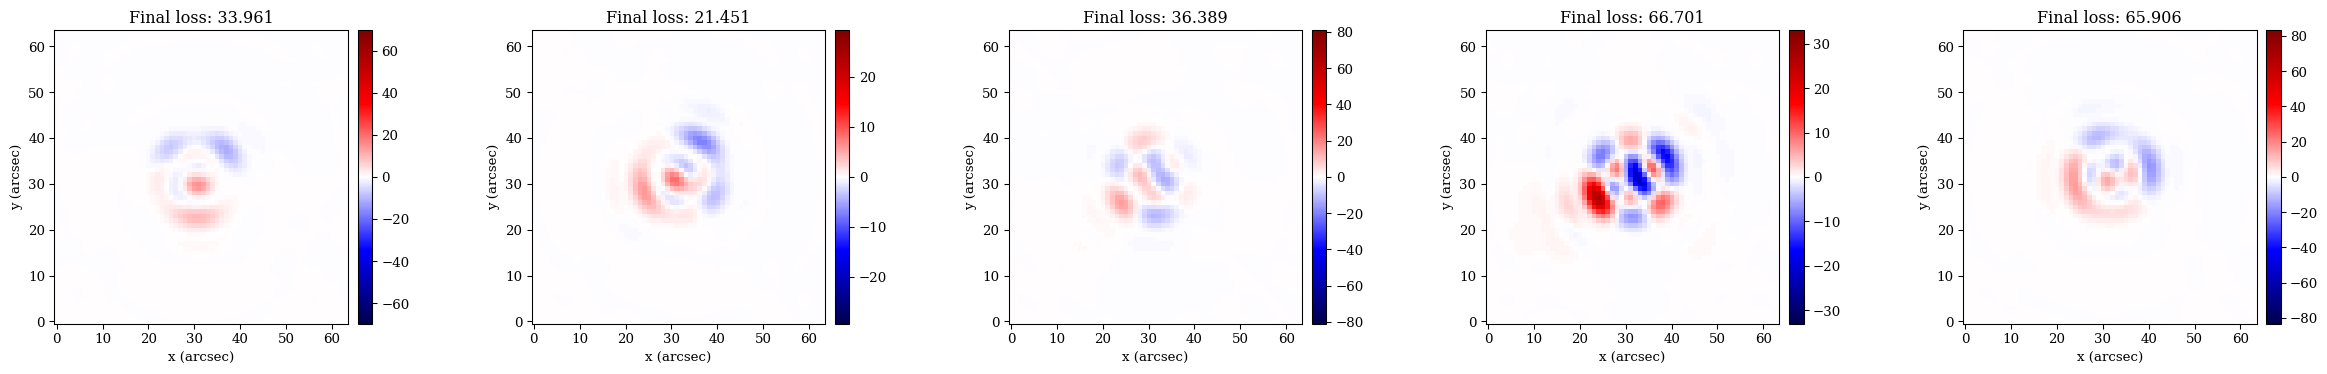

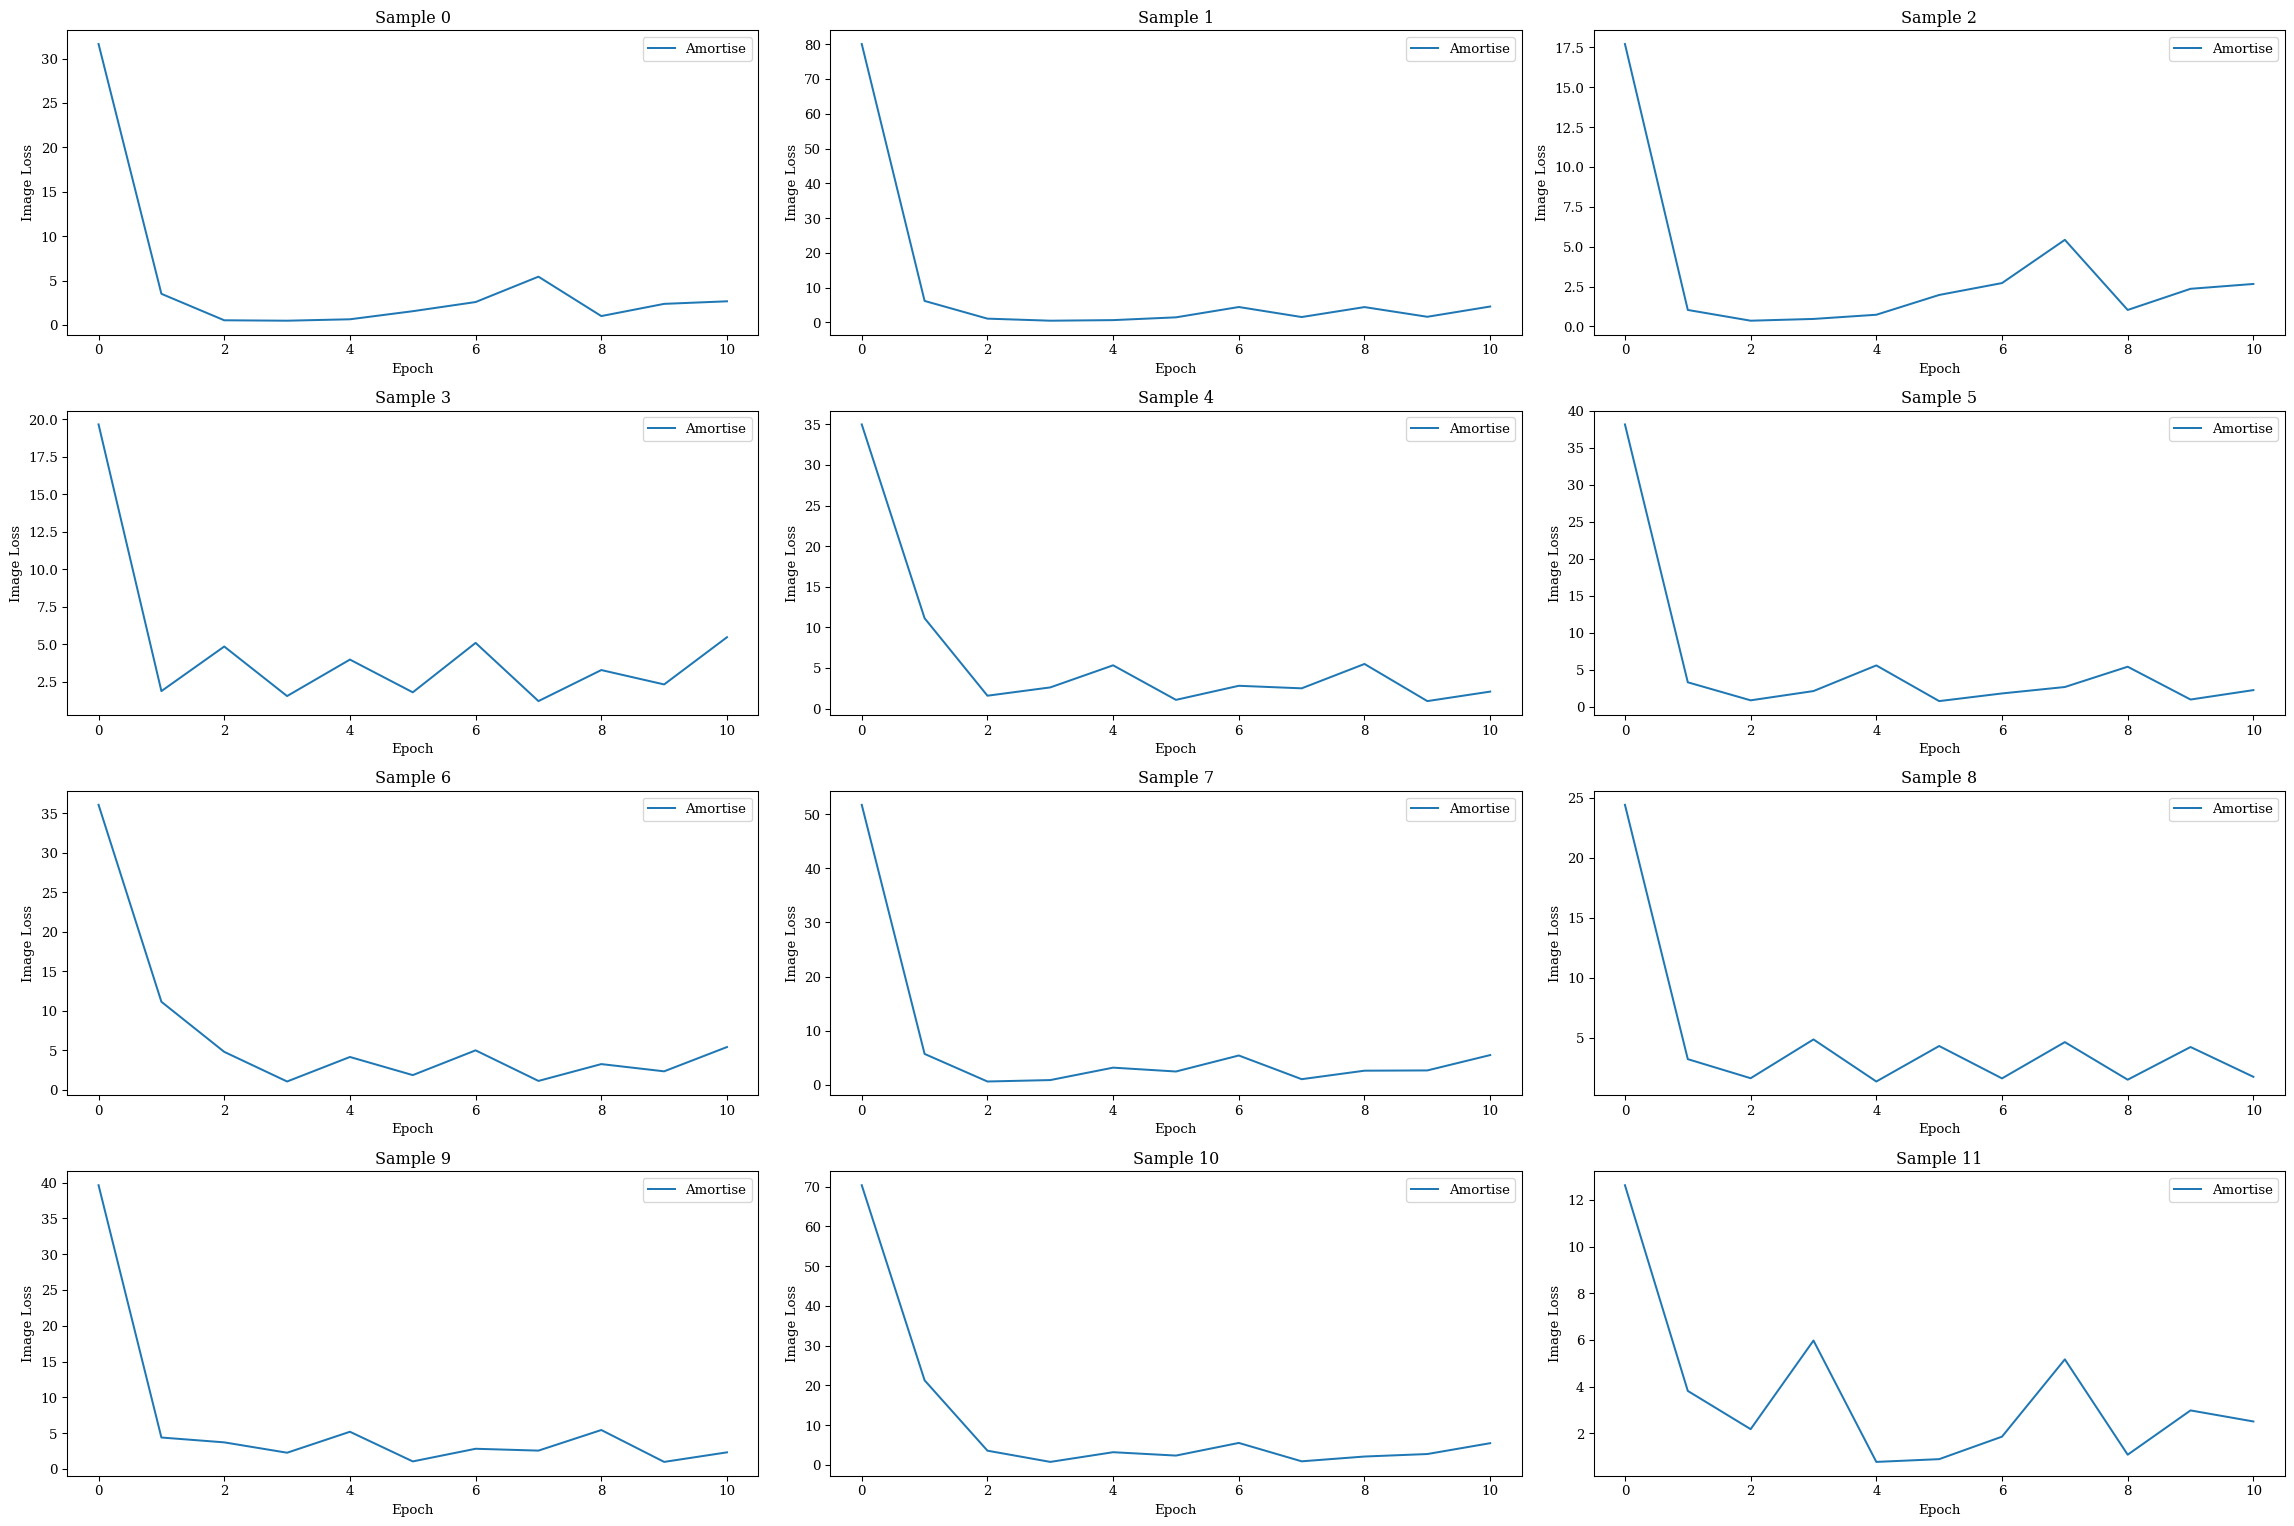

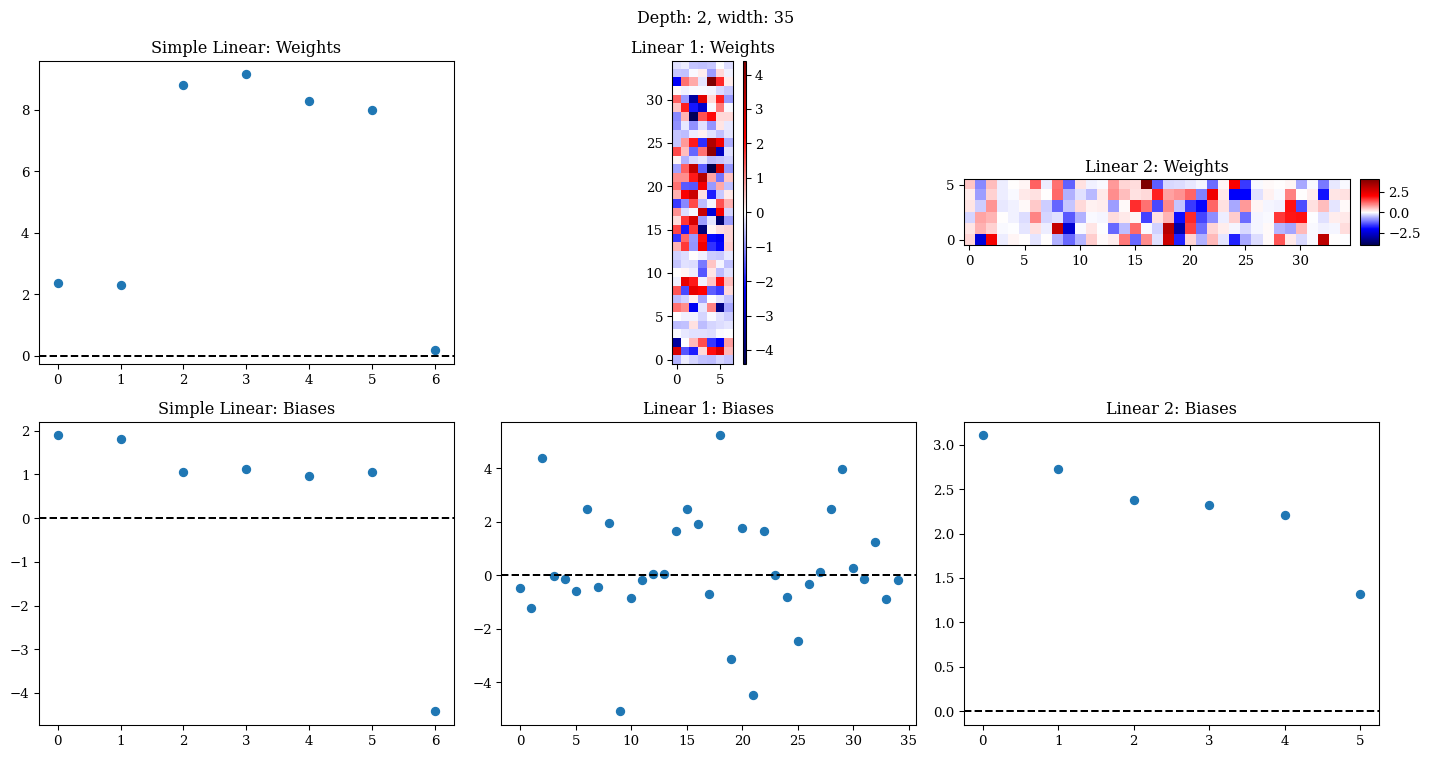

In [11]:
import numpy as onp

means = np.array(hyper_trainer.losses)[:, -1:].mean(1)
inds = np.argsort(means)
best = hyper_trainer.optimisers[inds[0]]
joint_model = eqx.tree_at(lambda tree: tree.optimiser, hyper_trainer.joint_model, best)


# Final loss vs hyper params
hypers_list = hyper_trainer.hypers
for mean, hyp in zip(means, hypers_list):
    hyp['loss'] = float(mean)
    hyp['lr'] = float(hyp['lr'])
    hyp['depth'] = int(hyp['depth'])
    hyp['width'] = int(hyp['width'])
dict_list = hypers_list

# Get a list of unique hyperparameter values
lr_values = sorted(set(d['lr'] for d in dict_list))
depth_values = sorted(set(d['depth'] for d in dict_list))
width_values = sorted(set(d['width'] for d in dict_list))

# Create a 3D array of losses for each combination of hyperparameters
loss_array = onp.zeros((len(lr_values), len(depth_values), len(width_values)))
for i, lr in enumerate(lr_values):
    for j, depth in enumerate(depth_values):
        for k, width in enumerate(width_values):
            for d in dict_list:
                if d['lr'] == lr and d['depth'] == depth and d['width'] == width:
                    loss_array[i, j, k] = d['loss']


vmin = np.min(loss_array)
fig, axes = forge.plot_grid_2d(1, len(width_values))
for i in range(len(width_values)):
    im = axes[i].imshow(loss_array[:, :, i], vmin=vmin, vmax=1)
    forge.add_cbar(fig, axes[i], im, label='final loss')
    axes[i].set(
        title=f'width: {width_values[i]}',
        xlabel='Depth',
        ylabel='Learning Rate',
        xticks=range(len(depth_values)),
        yticks=range(len(lr_values)),
        xticklabels=depth_values,
        yticklabels=[f"{np.log10(lr):.2f}" for lr in lr_values],
    )
fig.tight_layout()


# Plot samples and residuals
r, c = 1, 5
true, key = forge.sample(truth_prior, r * c, jr.PRNGKey(0))
# train, key = forge.sample(train_prior_2, r * c, key)
train, key = forge.sample(train_prior, r * c, key)

# Get target and sample psfs
target_psfs = joint_model.model_samples(true)
sample_psfs = joint_model.model_samples(train)

# Get predicted psfs
predicted = eqx.filter_vmap(joint_model.predict)(train, target_psfs)
predicted_psfs = joint_model.model_samples(predicted)

p = 0.5

# Plot truth
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(target_psfs[i]**p)
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        title=f"Truth {i}",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()

# Plot Train
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(sample_psfs[i]**p)
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        title=f"Train {i}",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()

# Plot Predicted
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(predicted_psfs[i]**p)
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        title=f"'Optimised' {i}",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()


# Examine predictions
# TODO: Make plot titles non-scientific notation for easier comparison
forge.examine_predictions(joint_model, truth_prior, train_prior, 1, 5)

# TODO: Plot prediction loss too - 'training loss' and 'image loss'
n_samples = 12
truth, key = forge.sample(truth_prior, 1, jr.PRNGKey(0))
samples, key = forge.sample(train_prior, n_samples, key)

psf = joint_model.model_sample(truth)
fig, axes = forge.plot_grid_2d(n_samples//3, 3, fsx=8)
for j in tqdm(range(n_samples)):
    # data = jr.poisson(jr.PRNGKey(j), psf)
    data = psf
    pred = samples[0][j]
    
    fmodel = joint_model.fmodel.set(joint_model.params, pred)
    initial_loss = joint_model.image_loss(fmodel, data)

    pred_losses = [initial_loss]
    for i in range(10):
        pred = joint_model.predict(pred, data)
        
        # Get losses
        fmodel = joint_model.fmodel.set(joint_model.params, pred)
        pred_losses.append(joint_model.image_loss(fmodel, data))
    
    axes[j].set(xlabel='Epoch', ylabel='Image Loss', title=f"Sample {j}")
    axes[j].plot(pred_losses, label='Amortise')
    axes[j].legend()
fig.tight_layout()


forge.visualise_optimiser(joint_model.optimiser)

Training 90 Optimisers over 1 steps on 1000 PSFs for 1000 epochs.
Total forwards model grad evaluations per epoch: 1000.
Compiling step function... Done! Took 80.49s


Best:   0%|          | 0/1000 [00:00<?, ?it/s]

LR:       0     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.01     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.03     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06     0.06      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1
Depth:    0        0        0        0        0        0        0        1        1        1        1        1        1        2        2        2        2        2        2     

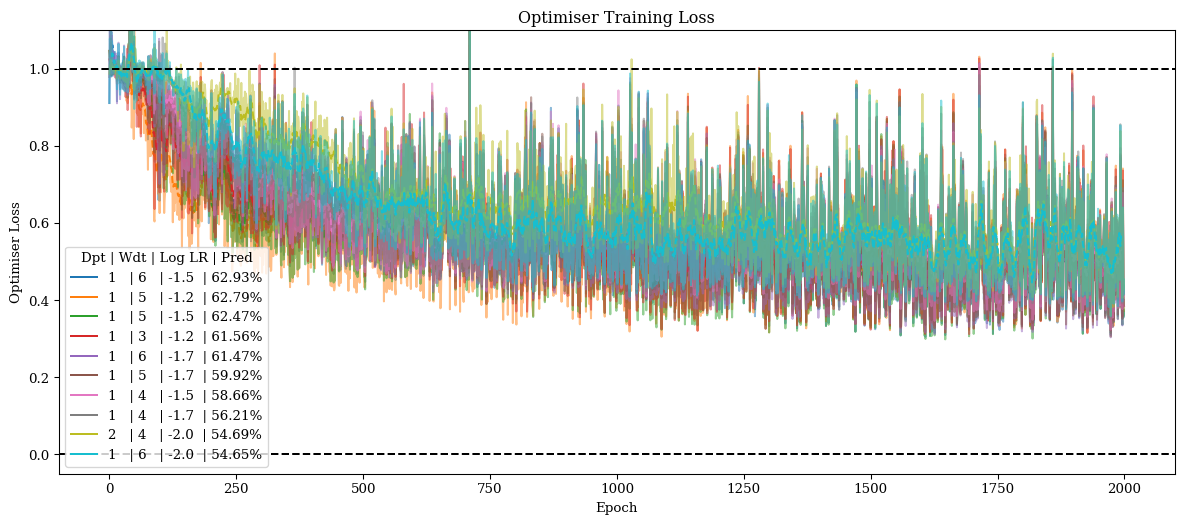

In [12]:
# Train
hyper_trainer, train_key = hyper_trainer.train_stochastic(
    truth_prior, train_prior, epochs=1000, batch_size=1000, key=train_key,
)
hyper_trainer.plot_losses()

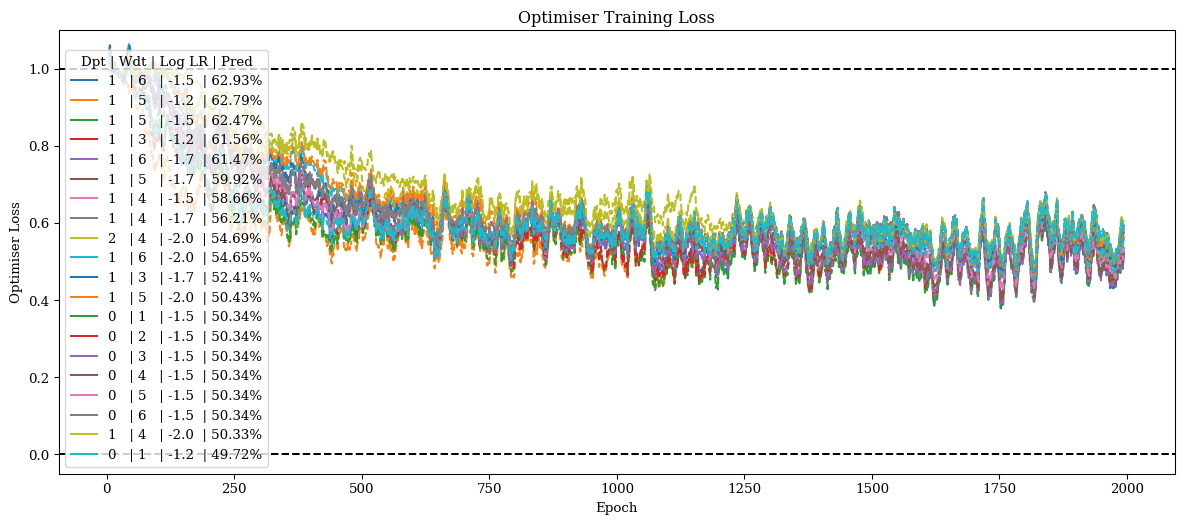

In [22]:
hyper_trainer.plot_losses(n_top=20, plot_losses=False)

  0%|          | 0/12 [00:00<?, ?it/s]

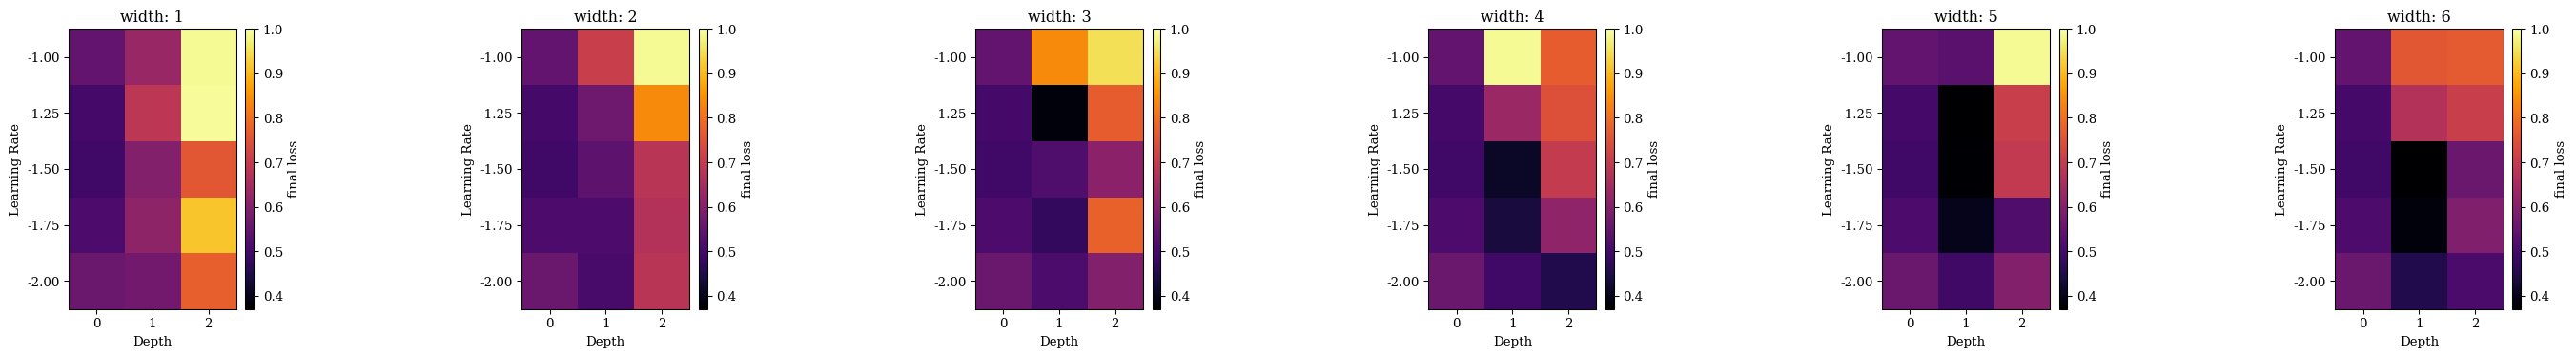

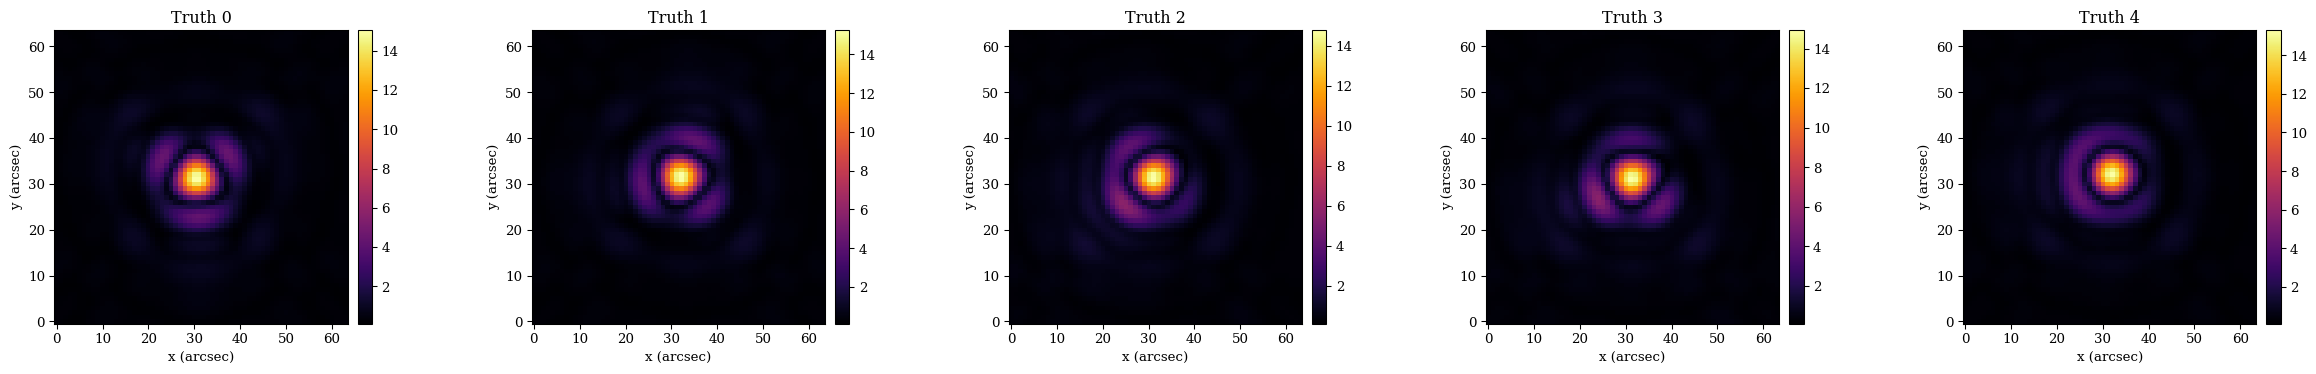

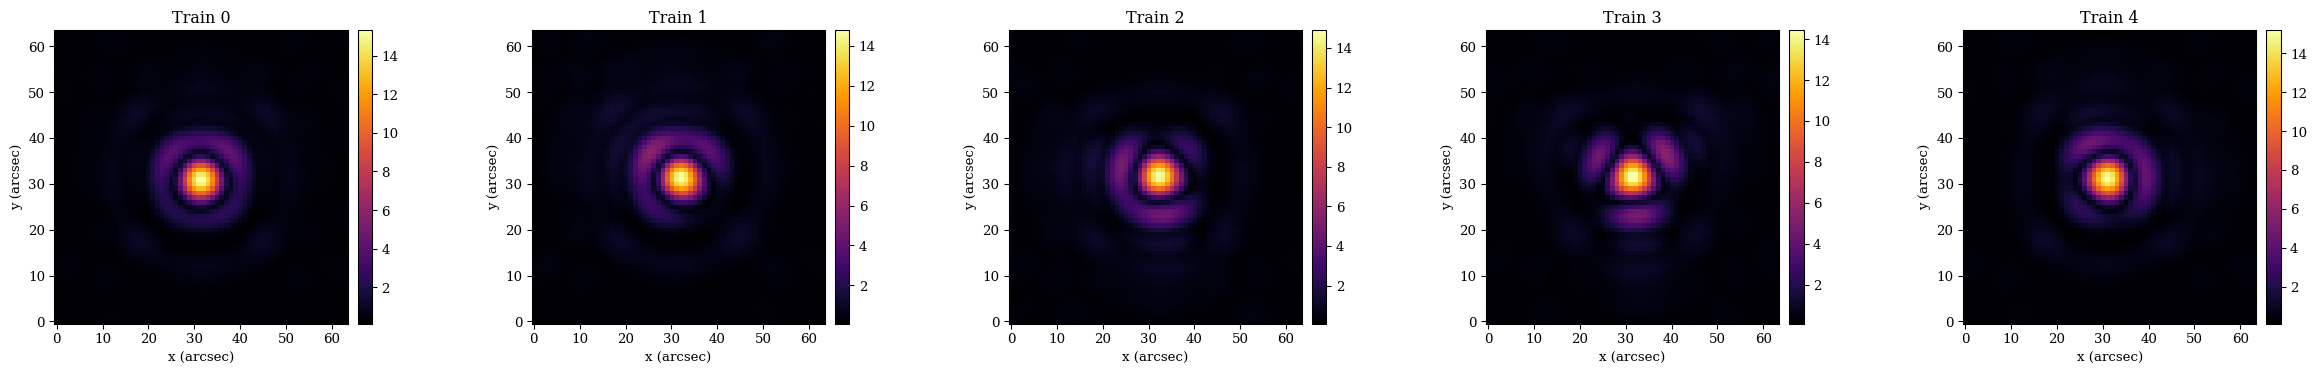

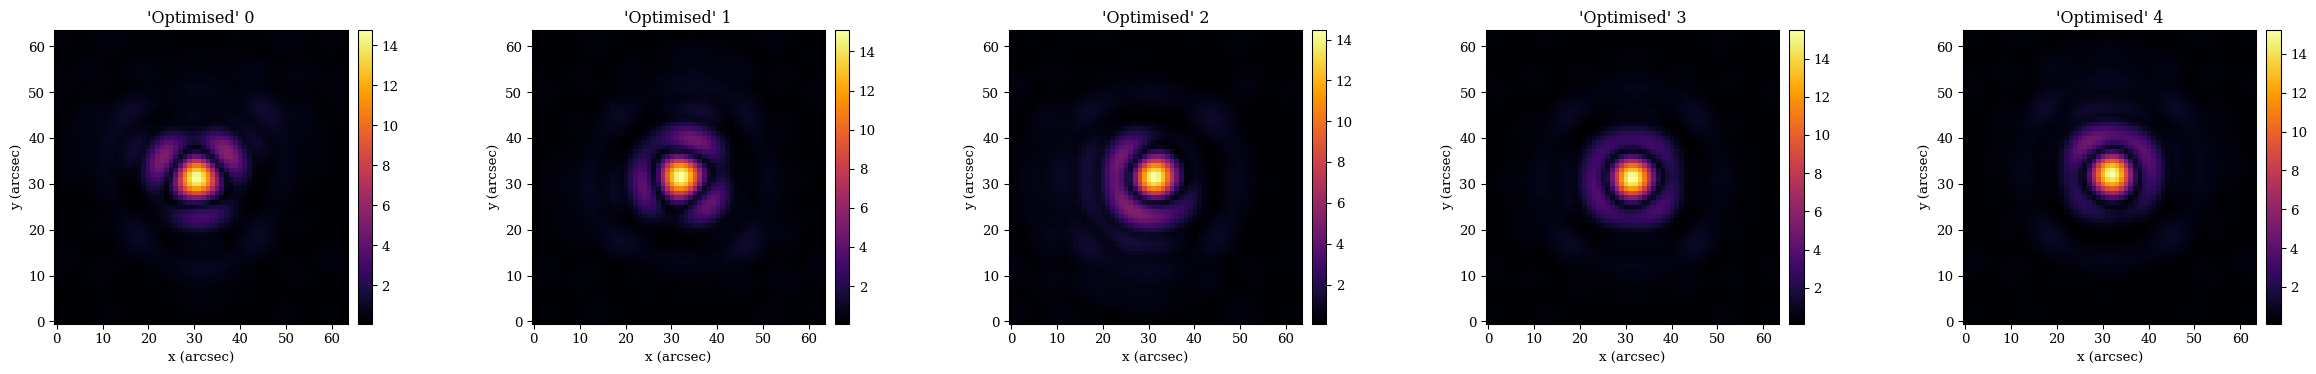

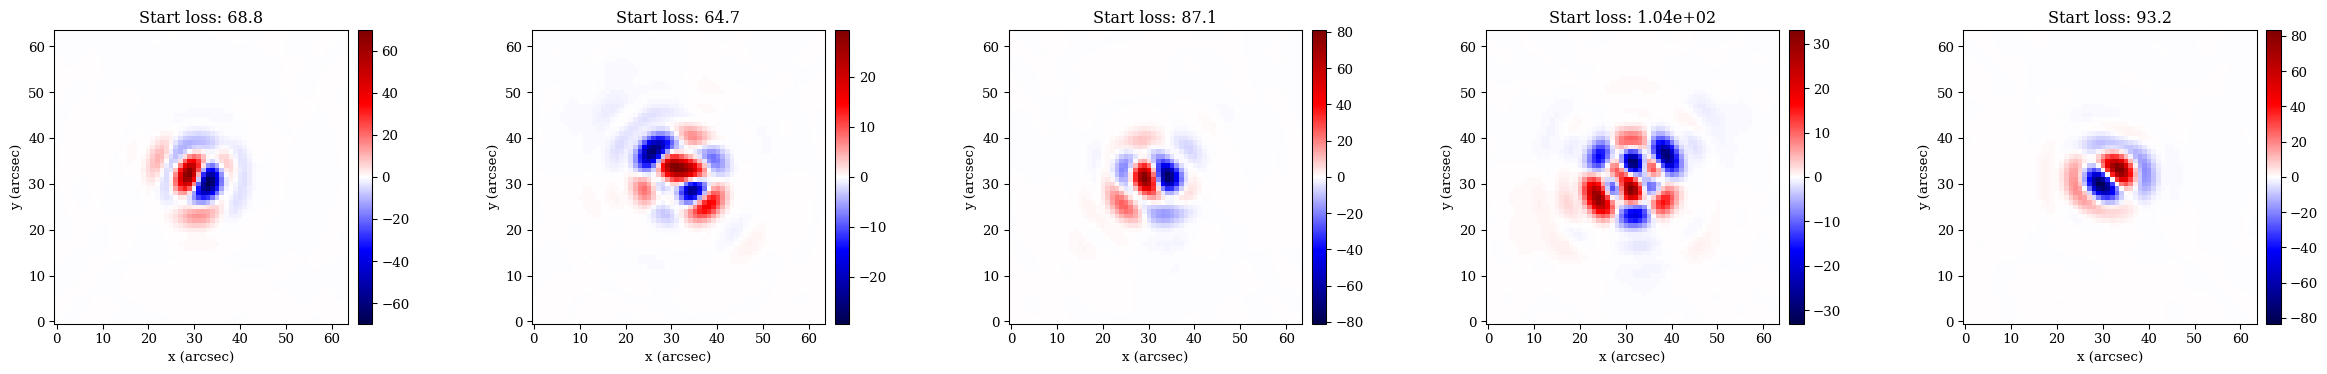

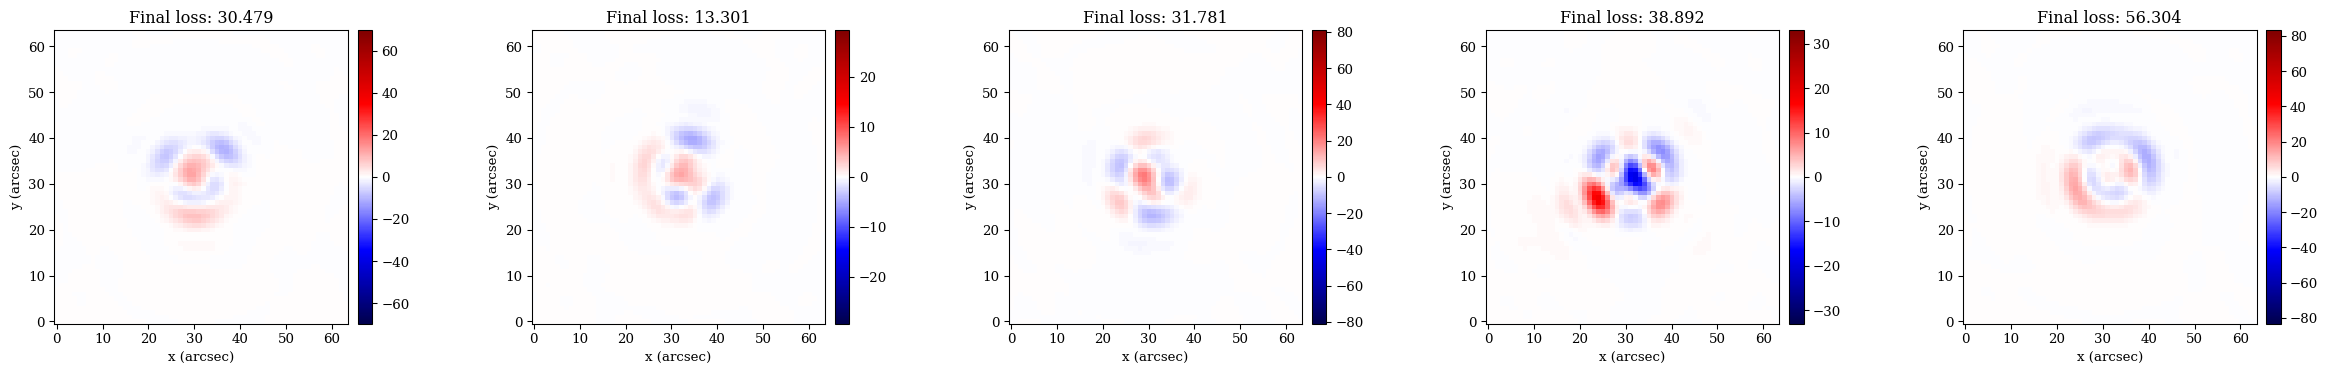

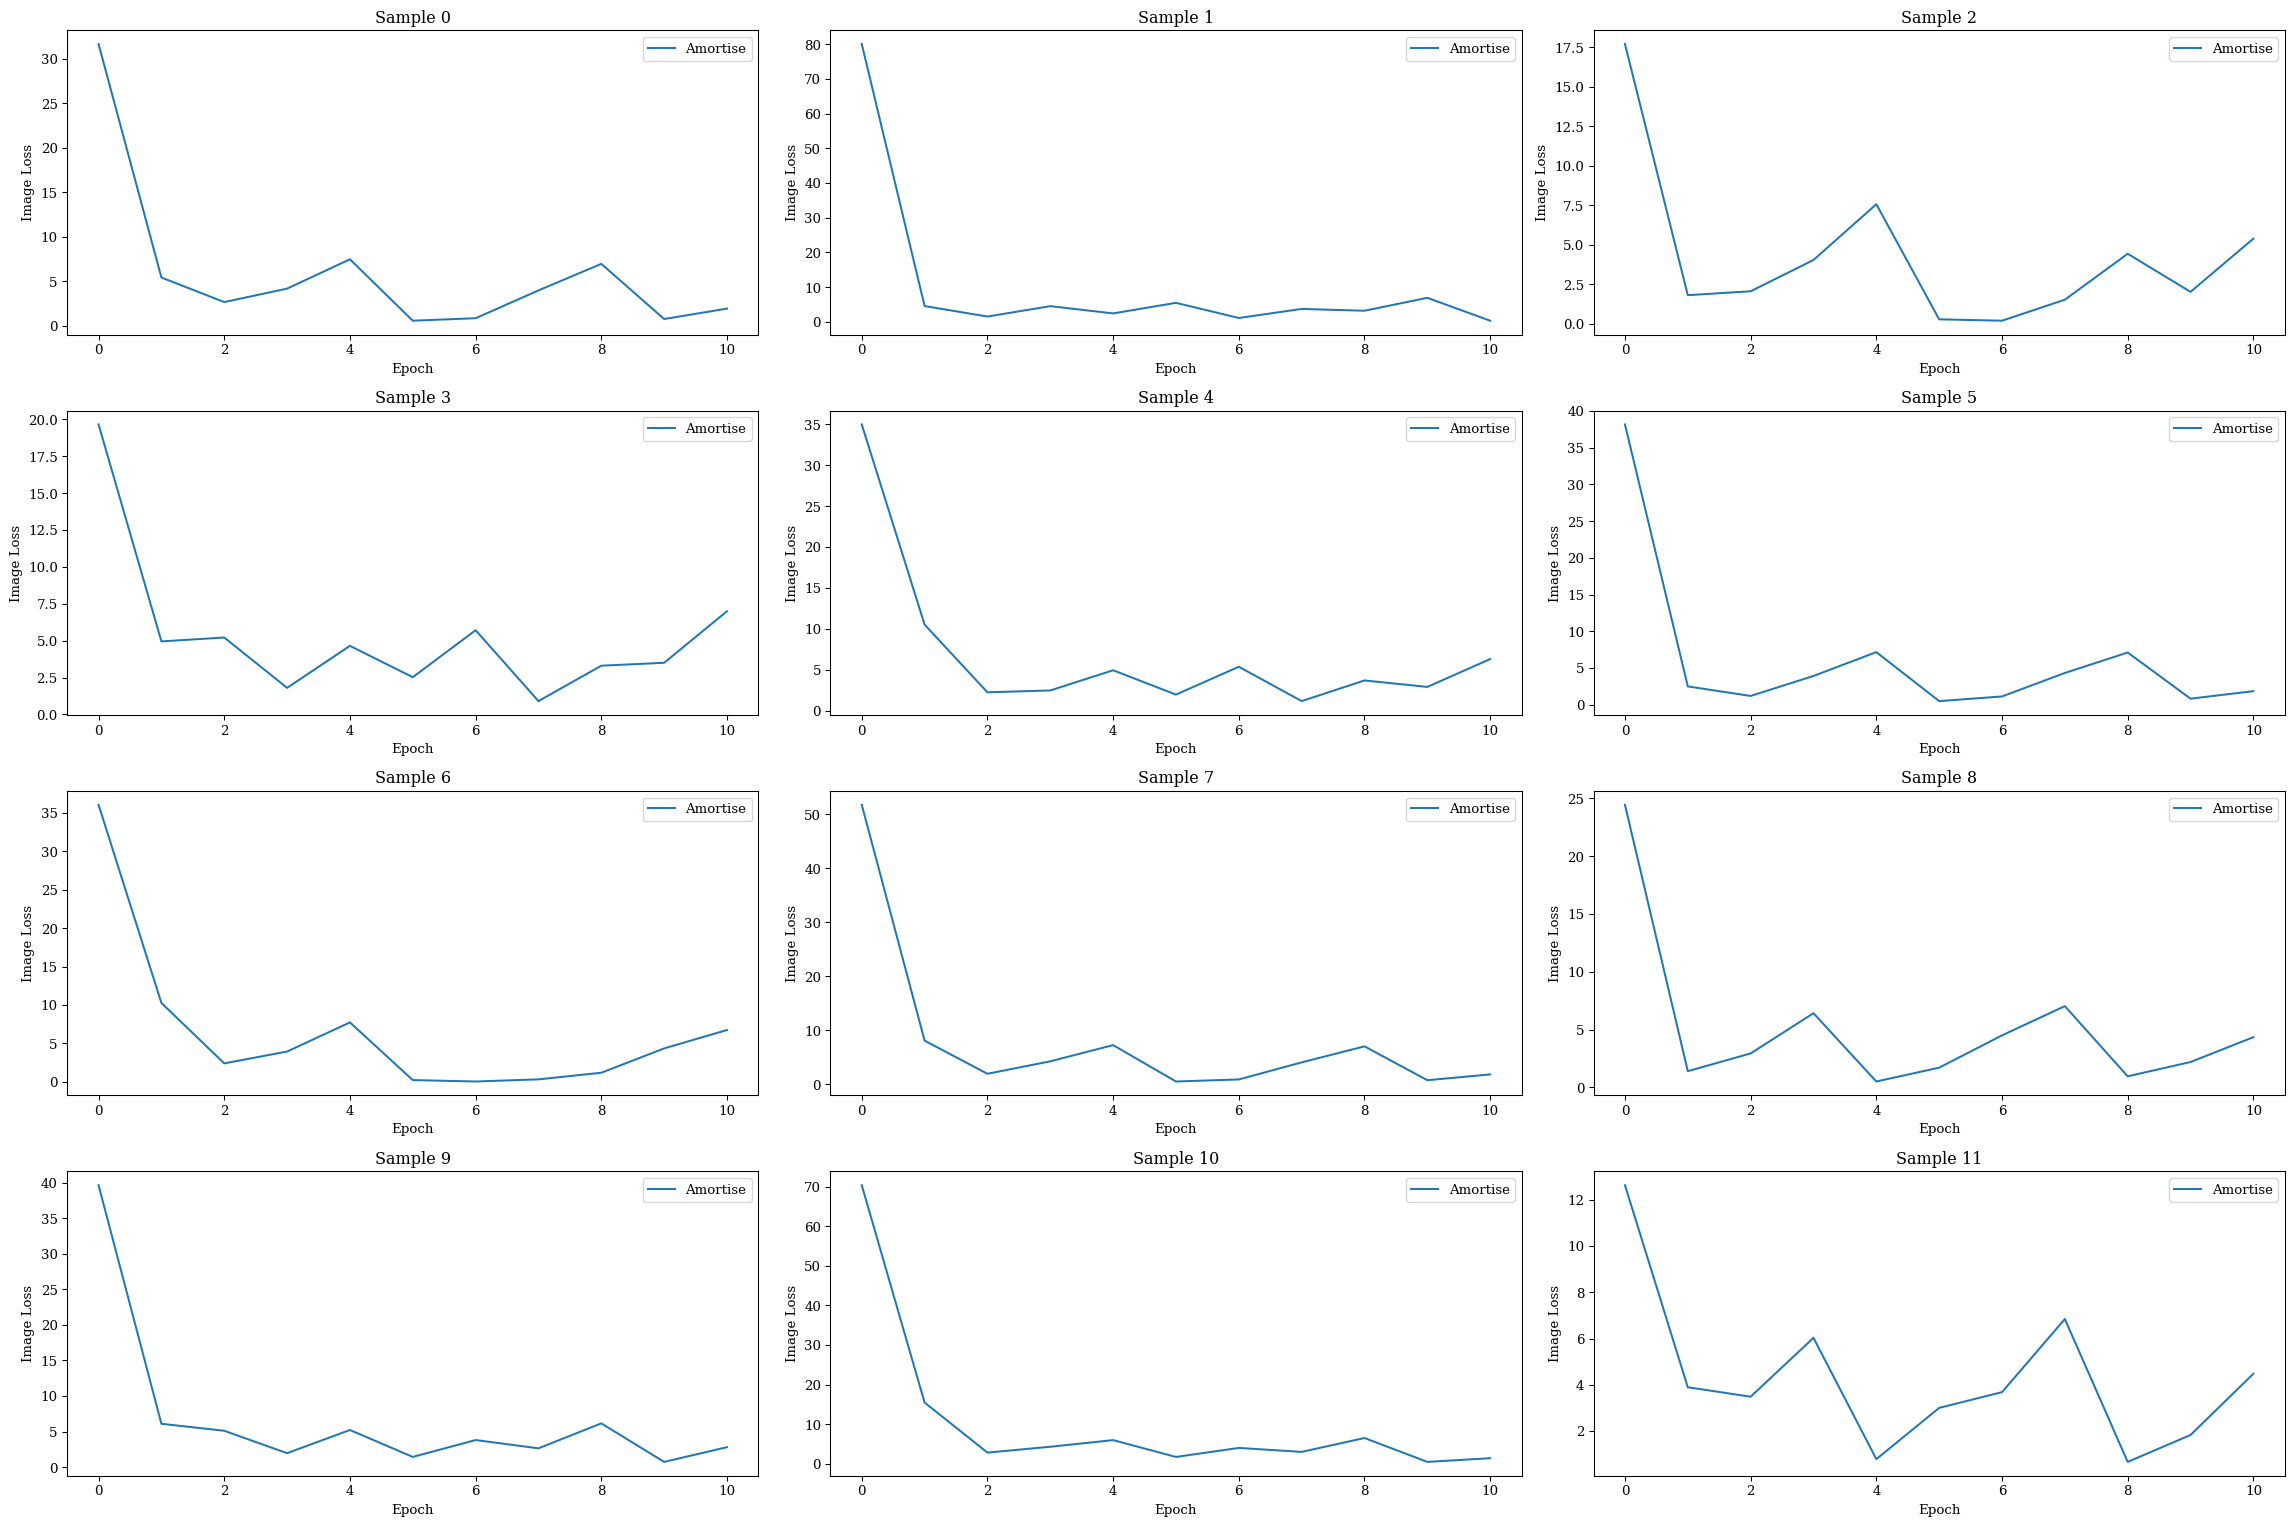

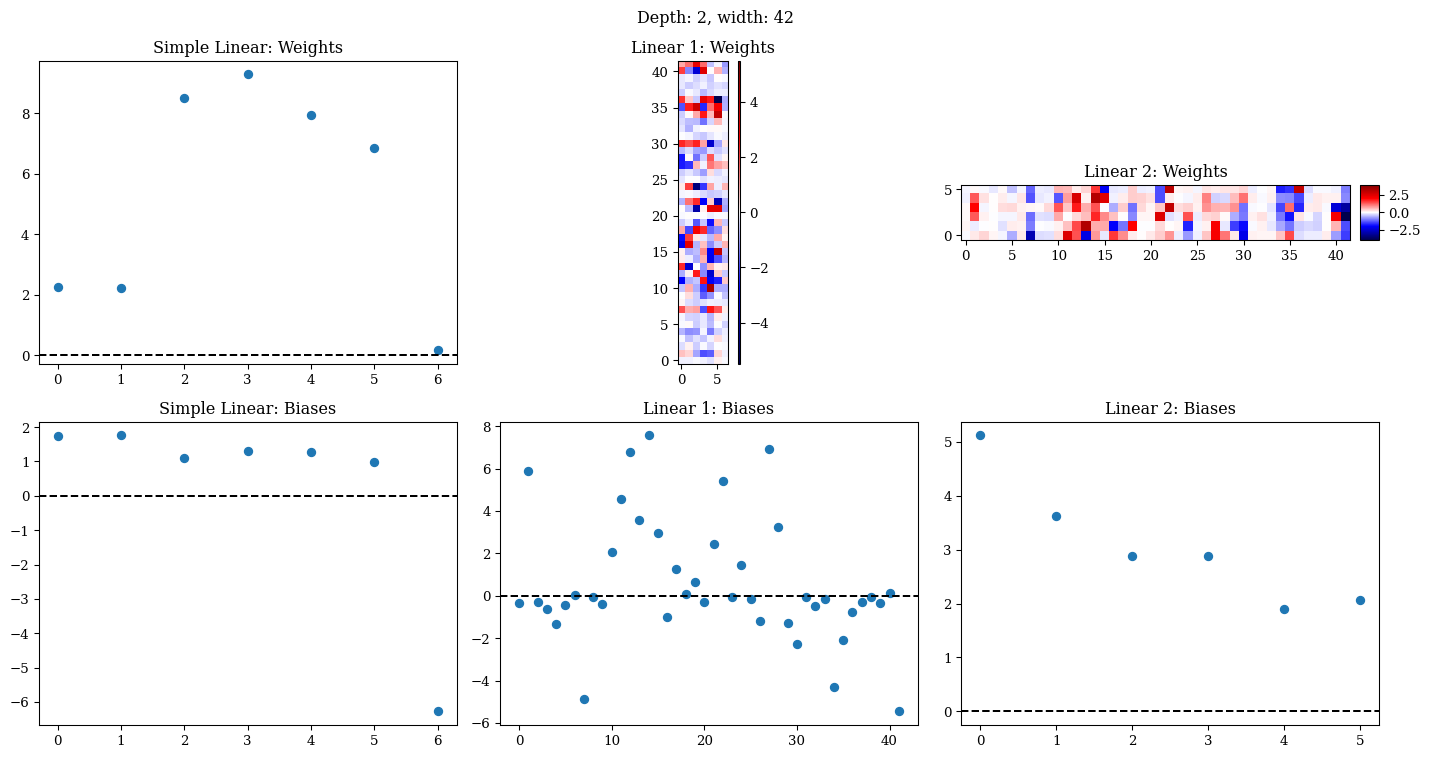

In [13]:
import numpy as onp

means = np.array(hyper_trainer.losses)[:, -1:].mean(1)
inds = np.argsort(means)
best = hyper_trainer.optimisers[inds[0]]
joint_model = eqx.tree_at(lambda tree: tree.optimiser, hyper_trainer.joint_model, best)


# Final loss vs hyper params
hypers_list = hyper_trainer.hypers
for mean, hyp in zip(means, hypers_list):
    hyp['loss'] = float(mean)
    hyp['lr'] = float(hyp['lr'])
    hyp['depth'] = int(hyp['depth'])
    hyp['width'] = int(hyp['width'])
dict_list = hypers_list

# Get a list of unique hyperparameter values
lr_values = sorted(set(d['lr'] for d in dict_list))
depth_values = sorted(set(d['depth'] for d in dict_list))
width_values = sorted(set(d['width'] for d in dict_list))

# Create a 3D array of losses for each combination of hyperparameters
loss_array = onp.zeros((len(lr_values), len(depth_values), len(width_values)))
for i, lr in enumerate(lr_values):
    for j, depth in enumerate(depth_values):
        for k, width in enumerate(width_values):
            for d in dict_list:
                if d['lr'] == lr and d['depth'] == depth and d['width'] == width:
                    loss_array[i, j, k] = d['loss']


vmin = np.min(loss_array)
fig, axes = forge.plot_grid_2d(1, len(width_values))
for i in range(len(width_values)):
    im = axes[i].imshow(loss_array[:, :, i], vmin=vmin, vmax=1)
    forge.add_cbar(fig, axes[i], im, label='final loss')
    axes[i].set(
        title=f'width: {width_values[i]}',
        xlabel='Depth',
        ylabel='Learning Rate',
        xticks=range(len(depth_values)),
        yticks=range(len(lr_values)),
        xticklabels=depth_values,
        yticklabels=[f"{np.log10(lr):.2f}" for lr in lr_values],
    )
fig.tight_layout()


# Plot samples and residuals
r, c = 1, 5
true, key = forge.sample(truth_prior, r * c, jr.PRNGKey(0))
# train, key = forge.sample(train_prior_2, r * c, key)
train, key = forge.sample(train_prior, r * c, key)

# Get target and sample psfs
target_psfs = joint_model.model_samples(true)
sample_psfs = joint_model.model_samples(train)

# Get predicted psfs
predicted = eqx.filter_vmap(joint_model.predict)(train, target_psfs)
predicted_psfs = joint_model.model_samples(predicted)

p = 0.5

# Plot truth
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(target_psfs[i]**p)
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        title=f"Truth {i}",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()

# Plot Train
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(sample_psfs[i]**p)
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        title=f"Train {i}",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()

# Plot Predicted
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(predicted_psfs[i]**p)
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        title=f"'Optimised' {i}",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()


# Examine predictions
forge.examine_predictions(joint_model, truth_prior, train_prior, 1, 5)

# TODO: Plot prediction loss too - 'training loss' and 'image loss'
n_samples = 12
truth, key = forge.sample(truth_prior, 1, jr.PRNGKey(0))
samples, key = forge.sample(train_prior, n_samples, key)

psf = joint_model.model_sample(truth)
fig, axes = forge.plot_grid_2d(n_samples//3, 3, fsx=8)
for j in tqdm(range(n_samples)):
    # data = jr.poisson(jr.PRNGKey(j), psf)
    data = psf
    pred = samples[0][j]
    
    fmodel = joint_model.fmodel.set(joint_model.params, pred)
    initial_loss = joint_model.image_loss(fmodel, data)

    pred_losses = [initial_loss]
    for i in range(10):
        pred = joint_model.predict(pred, data)
        
        # Get losses
        fmodel = joint_model.fmodel.set(joint_model.params, pred)
        pred_losses.append(joint_model.image_loss(fmodel, data))
    
    axes[j].set(xlabel='Epoch', ylabel='Image Loss', title=f"Sample {j}")
    axes[j].plot(pred_losses, label='Amortise')
    axes[j].legend()
fig.tight_layout()


forge.visualise_optimiser(joint_model.optimiser)

  0%|          | 0/6 [00:00<?, ?it/s]

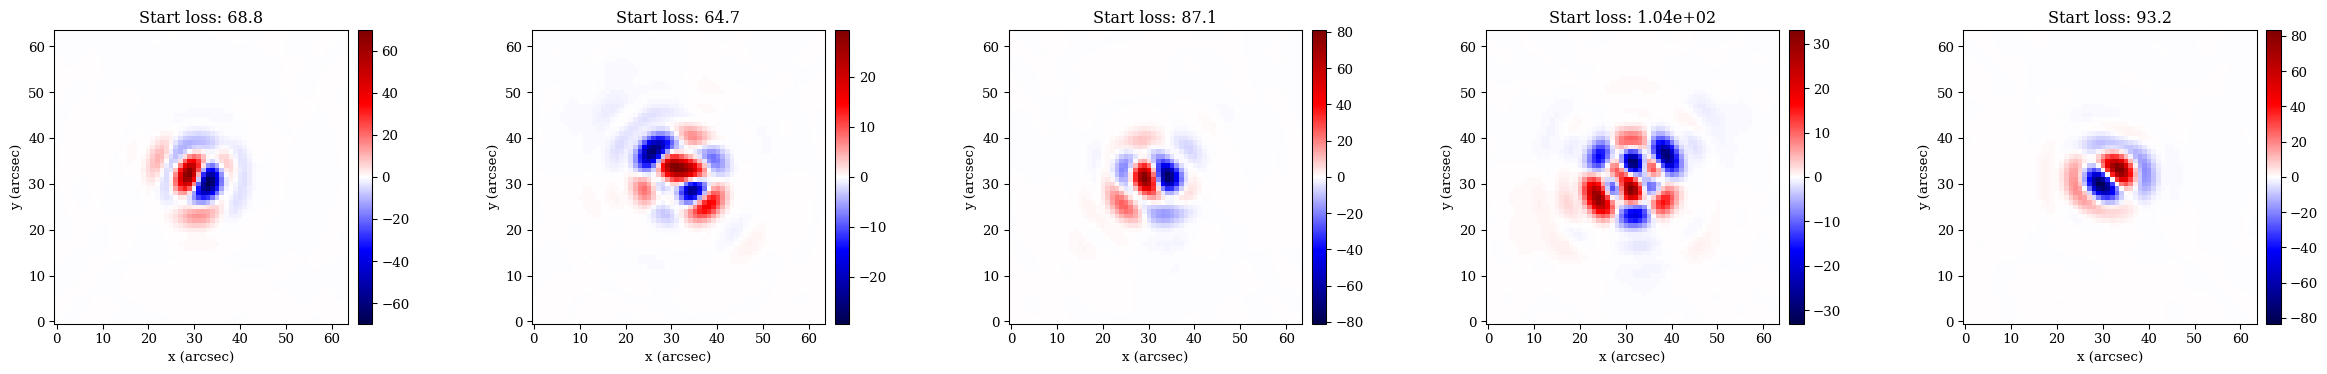

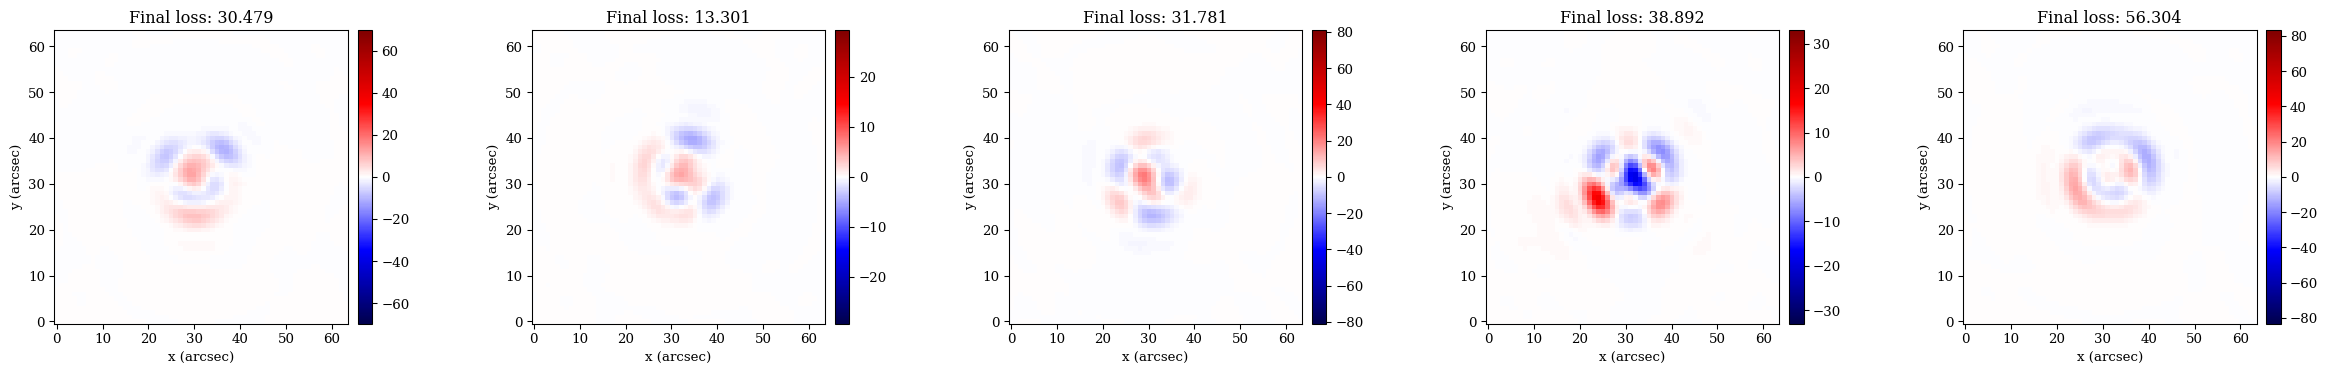

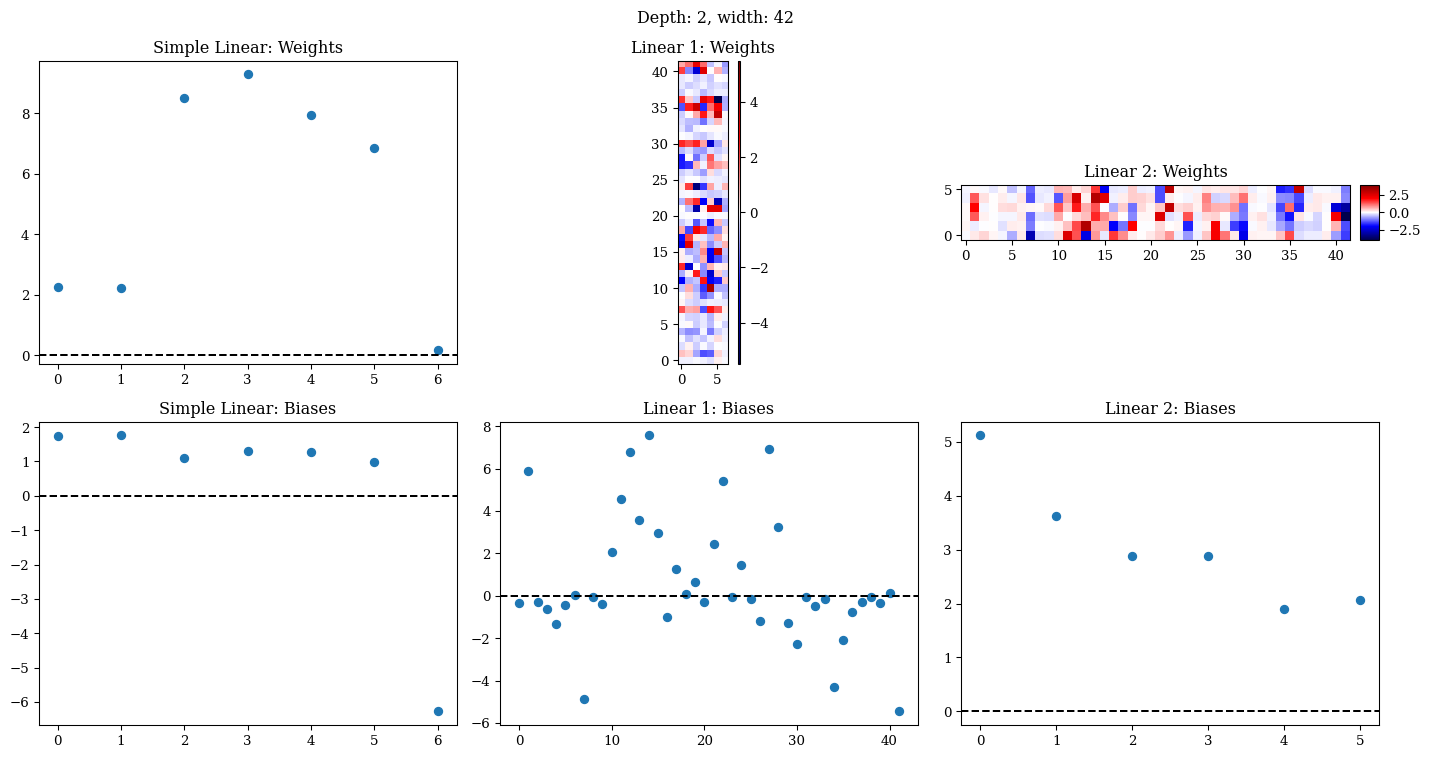

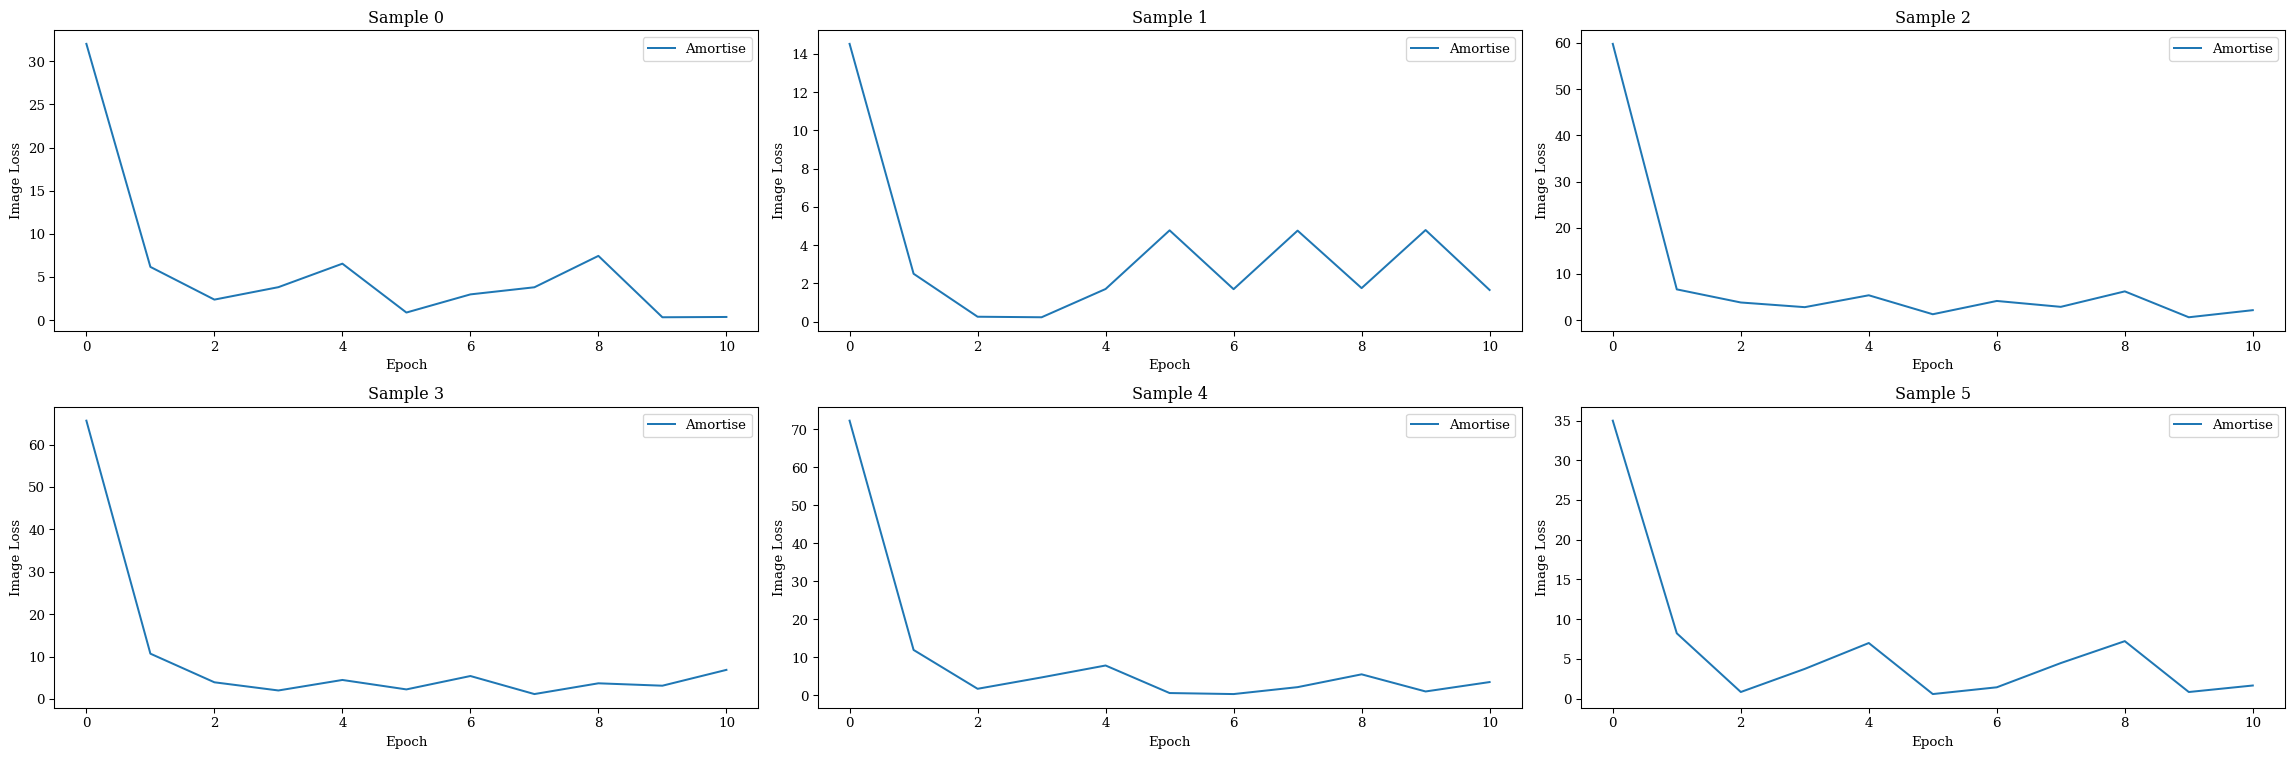

In [14]:
# We can examine the initialisation conditions here if we want
# TODO: AAAAGHGH This stupid function is bugged I dont know why, dont use it.
# joint_model, hyper = hyper_trainer.get_top(1)


means = np.array(hyper_trainer.losses)[:, -1:].mean(1)
inds = np.argsort(means)
best = hyper_trainer.optimisers[inds[0]]
joint_model = eqx.tree_at(lambda tree: tree.optimiser, hyper_trainer.joint_model, best)


forge.examine_predictions(joint_model, truth_prior, train_prior, 1, 5)
forge.visualise_optimiser(joint_model.optimiser)

# TODO: Plot prediction loss too - 'training loss' and 'image loss'
n_samples = 6
truth, key = forge.sample(truth_prior, 1, jr.PRNGKey(0))
samples, key = forge.sample(train_prior, n_samples, key)

psf = joint_model.model_sample(truth)
fig, axes = forge.plot_grid_2d(2, n_samples//2, fsx=8)
for j in tqdm(range(n_samples)):
    # data = jr.poisson(jr.PRNGKey(j), psf)
    data = psf
    pred = samples[0][j]
    
    fmodel = joint_model.fmodel.set(joint_model.params, pred)
    initial_loss = joint_model.image_loss(fmodel, data)

    pred_losses = [initial_loss]
    for i in range(10):
        pred = joint_model.predict(pred, data)
        
        # Get losses
        fmodel = joint_model.fmodel.set(joint_model.params, pred)
        pred_losses.append(joint_model.image_loss(fmodel, data))
    
    axes[j].set(xlabel='Epoch', ylabel='Image Loss', title=f"Sample {j}")
    axes[j].plot(pred_losses, label='Amortise')
    axes[j].legend()
fig.tight_layout()

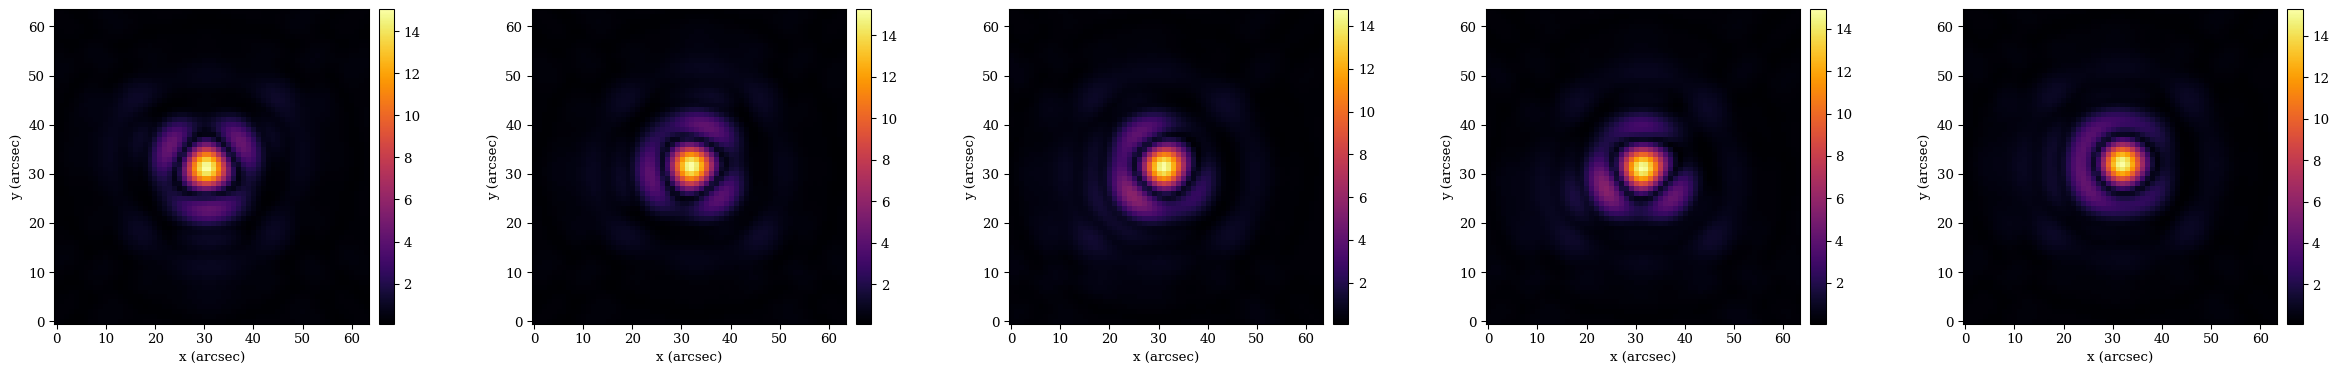

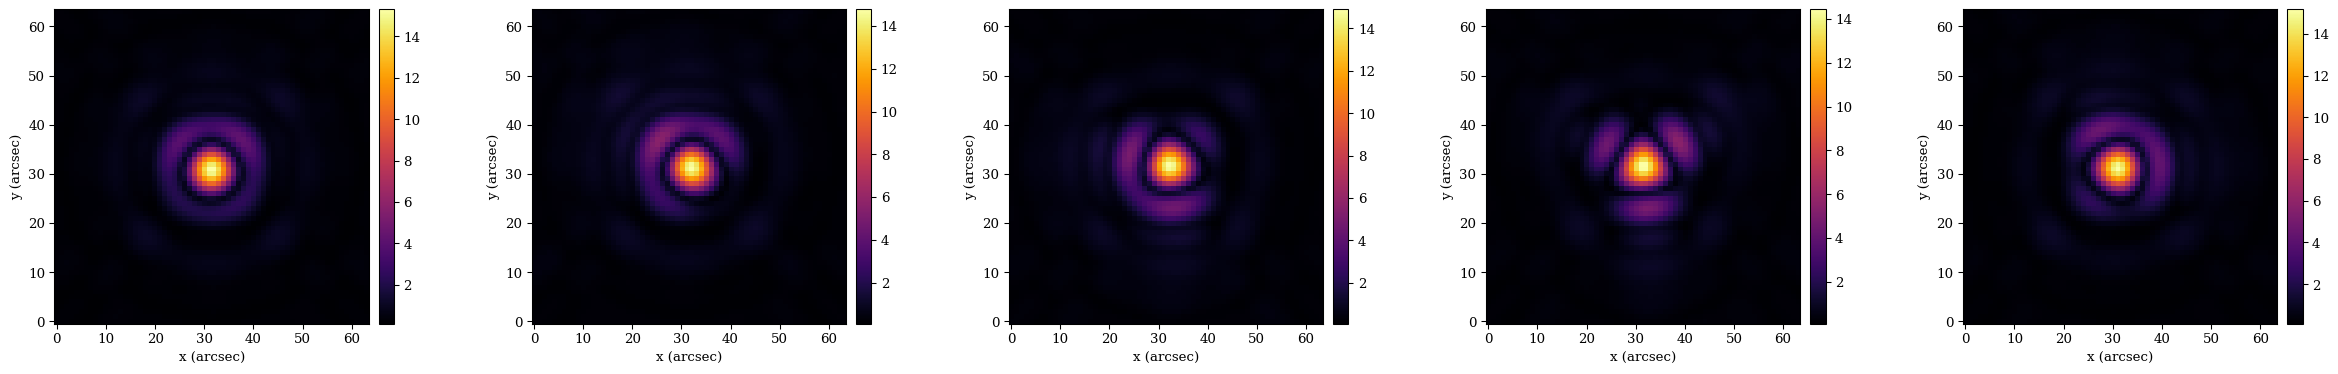

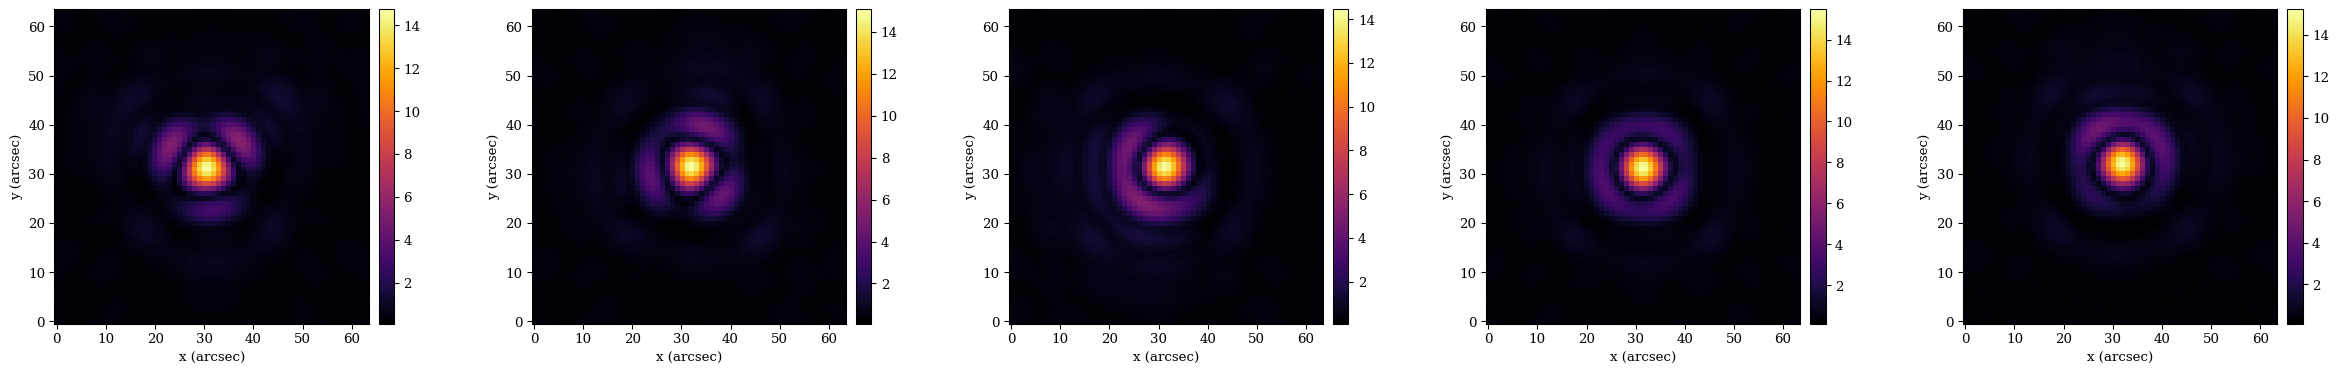

In [15]:
r, c = 1, 5
true, key = forge.sample(truth_prior, r * c, jr.PRNGKey(0))
train, key = forge.sample(train_prior, r * c, key)

# Get target and sample psfs
target_psfs = joint_model.model_samples(true)
sample_psfs = joint_model.model_samples(train)

# Get predicted psfs
predicted = eqx.filter_vmap(joint_model.predict)(train, target_psfs)
predicted_psfs = joint_model.model_samples(predicted)

p = 0.5

# Plot truth - sample points
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(target_psfs[i]**p)#, cmap="seismic", vmin=-vs[i], vmax=vs[i])
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        # title=f"Start loss: {initial_loss[i]:.3}",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()

# Plot truth - predicted
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(sample_psfs[i]**p)#, cmap="seismic", vmin=-vs[i], vmax=vs[i])
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        # title=f"Final loss: {final_losses[i]:.3f}",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()

# Plot truth - predicted
fig, ax = forge.plot_grid_2d(r, c)
for i in range(r * c):
    im = ax[i].imshow(predicted_psfs[i]**p)#, cmap="seismic", vmin=-vs[i], vmax=vs[i])
    ax[i].set(
        xlabel="x (arcsec)",
        ylabel="y (arcsec)",
        # title=f"Final loss: {final_losses[i]:.3f}",
    )
    forge.add_cbar(fig, ax[i], im)
fig.tight_layout()

## Re-Train

Re-Train with a wider training prior

In [16]:
# train_prior_2 = [forge.Normal(mu=0, sigma=200, bc_shape=coeffs.shape)]

# # ReTrain
# hyper_trainer, train_key = hyper_trainer.train_stochastic(
#     truth_prior, train_prior_2, epochs=500, batch_size=1000, key=train_key,
# )
# hyper_trainer.plot_losses()

In [17]:
# hyper_trainer.plot_losses(n_top=20)


In [18]:
# # We can examine the initialisation conditions here if we want
# # TODO: AAAAGHGH This stupid function is bugged I dont know why, dont use it.
# # joint_model, hyper = hyper_trainer.get_top(1)

# means = np.array(hyper_trainer.losses)[:, -1:].mean(1)
# inds = np.argsort(means)
# best = hyper_trainer.optimisers[inds[0]]
# joint_model = eqx.tree_at(lambda tree: tree.optimiser, hyper_trainer.joint_model, best)


# forge.examine_predictions(joint_model, truth_prior, train_prior, 1, 5)
# forge.visualise_optimiser(joint_model.optimiser)

# # TODO: Plot prediction loss too - 'training loss' and 'image loss'
# n_samples = 6
# truth, key = forge.sample(truth_prior, 1, jr.PRNGKey(0))
# samples, key = forge.sample(train_prior, n_samples, key)

# psf = joint_model.model_sample(truth)
# fig, axes = forge.plot_grid_2d(2, n_samples//2, fsx=8)
# for j in tqdm(range(n_samples)):
#     # data = jr.poisson(jr.PRNGKey(j), psf)
#     data = psf
#     pred = samples[0][j]
    
#     fmodel = joint_model.fmodel.set(joint_model.params, pred)
#     initial_loss = joint_model.image_loss(fmodel, data)

#     pred_losses = [initial_loss]
#     for i in range(10):
#         pred = joint_model.predict(pred, data)
        
#         # Get losses
#         fmodel = joint_model.fmodel.set(joint_model.params, pred)
#         pred_losses.append(joint_model.image_loss(fmodel, data))
    
#     axes[j].set(xlabel='Epoch', ylabel='Image Loss', title=f"Sample {j}")
#     axes[j].plot(pred_losses, label='Amortise')
#     axes[j].legend()
# fig.tight_layout()

In [19]:
# r, c = 1, 5
# true, key = forge.sample(truth_prior, r * c, jr.PRNGKey(0))
# train, key = forge.sample(train_prior_2, r * c, key)

# # Get target and sample psfs
# target_psfs = joint_model.model_samples(true)
# sample_psfs = joint_model.model_samples(train)

# # Get predicted psfs
# predicted = eqx.filter_vmap(joint_model.predict)(train, target_psfs)
# predicted_psfs = joint_model.model_samples(predicted)

# p = 0.5

# # Plot truth - sample points
# fig, ax = forge.plot_grid_2d(r, c)
# for i in range(r * c):
#     im = ax[i].imshow(target_psfs[i]**p)#, cmap="seismic", vmin=-vs[i], vmax=vs[i])
#     ax[i].set(
#         xlabel="x (arcsec)",
#         ylabel="y (arcsec)",
#         # title=f"Start loss: {initial_loss[i]:.3}",
#     )
#     forge.add_cbar(fig, ax[i], im)
# fig.tight_layout()

# # Plot truth - predicted
# fig, ax = forge.plot_grid_2d(r, c)
# for i in range(r * c):
#     im = ax[i].imshow(sample_psfs[i]**p)#, cmap="seismic", vmin=-vs[i], vmax=vs[i])
#     ax[i].set(
#         xlabel="x (arcsec)",
#         ylabel="y (arcsec)",
#         # title=f"Final loss: {final_losses[i]:.3f}",
#     )
#     forge.add_cbar(fig, ax[i], im)
# fig.tight_layout()

# # Plot truth - predicted
# fig, ax = forge.plot_grid_2d(r, c)
# for i in range(r * c):
#     im = ax[i].imshow(predicted_psfs[i]**p)#, cmap="seismic", vmin=-vs[i], vmax=vs[i])
#     ax[i].set(
#         xlabel="x (arcsec)",
#         ylabel="y (arcsec)",
#         # title=f"Final loss: {final_losses[i]:.3f}",
#     )
#     forge.add_cbar(fig, ax[i], im)
# fig.tight_layout()

In [20]:
# train_prior_2 = [forge.Normal(mu=0, sigma=300, bc_shape=coeffs.shape)]

# # ReTrain
# hyper_trainer, train_key = hyper_trainer.train_stochastic(
#     truth_prior, train_prior_2, epochs=500, batch_size=1000, key=train_key,
# )
# hyper_trainer.plot_losses()